In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_household_electricity_data

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    drop_null_rows,
)

from src.evaluation import evaluate

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [3]:
dataframe = (
    load_household_electricity_data()
    .pipe(format_datetime, col="Date_Time")
    .pipe(set_index, col="Date_Time")
    .pipe(resample_Data, freq="H")
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (2075259, 8)
set_index: DF Shape (2075259, 7)
resample_Data: DF Shape (34589, 7)
dataframe shape (34589, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34589 entries, 2006-12-16 17:00:00 to 2010-11-26 21:00:00
Freq: H
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    34589 non-null  float64
 1   Global_reactive_power  34589 non-null  float64
 2   Voltage                34589 non-null  float64
 3   Global_intensity       34589 non-null  float64
 4   Sub_metering_1         34589 non-null  float64
 5   Sub_metering_2         34589 non-null  float64
 6   Sub_metering_3         34589 non-null  float64
dtypes: float64(7)
memory usage: 2.1 MB
None


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [4]:
dataframe = dataframe[-1825:].copy()
dataframe.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

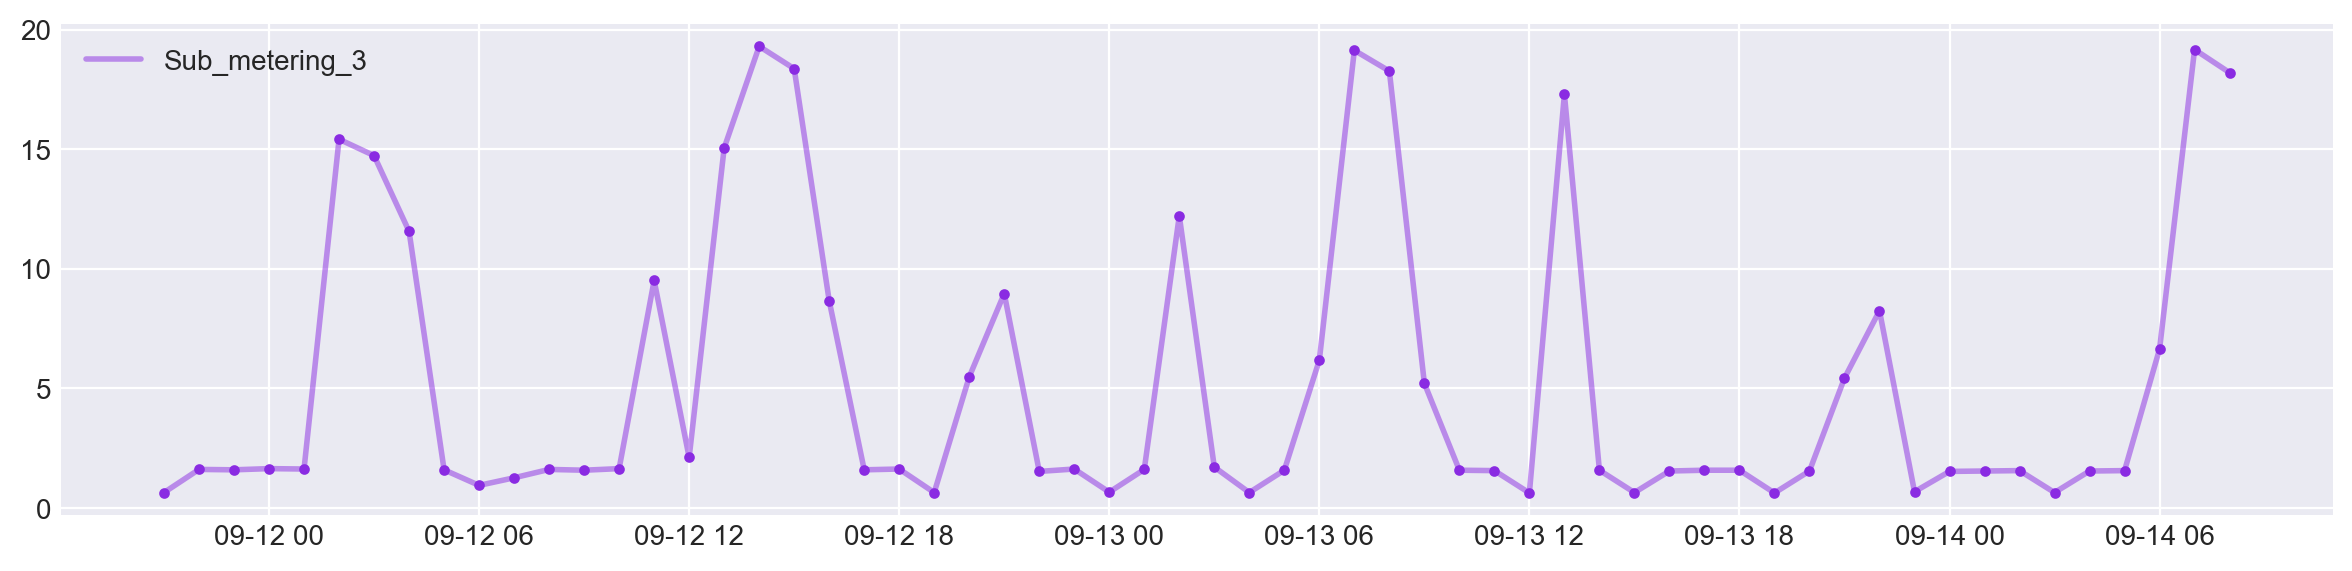

In [5]:
show_dataset(dataframe[:60], columns=["Sub_metering_3"])

In [6]:
DT_FEATURES = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
CYCLIC_FEATURE = ["day", "month", "year"]
LAGS = [1, 2]
FEATURE_WINDOW_LEN = 3

TARGET_COLUMN = "Sub_metering_3"
TEST_SIZE = 30

In [7]:
print(f"dataframe shape {dataframe.shape}")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=TARGET_COLUMN, lags=LAGS)
    .pipe(create_window_feature, column=TARGET_COLUMN, window_len=FEATURE_WINDOW_LEN)
    .pipe(create_datetime_feature, features_name=DT_FEATURES)
    .pipe(create_cyclic_feature, features_name=CYCLIC_FEATURE)
    .pipe(drop_null_rows)
)

df_feat = build_features(dataframe)

print(f"dataframe shape after Feature Union {df_feat.shape}", end="\n\n")

train_data, test_data = test_train_split(df_feat, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ", end="\n\n")

train_x, train_y = seperate_target(train_data, TARGET_COLUMN)
test_x, test_y = seperate_target(test_data, TARGET_COLUMN)

print(f"train_x shape after seperate_target {train_x.shape}")
print(f"train_y shape after seperate_target {train_y.shape}")
print(f"test_x  shape after seperate_target {test_x.shape}")
print(f"test_y  shape after seperate_target {test_y.shape}")

dataframe shape (1825, 7)
dataframe shape after Feature Union (1822, 26)

Train Size after Test_Train Split: (1792, 26)
Test  Size after Test_Train Split: (30, 26) 

train_x shape after seperate_target (1792, 25)
train_y shape after seperate_target (1792, 1)
test_x  shape after seperate_target (30, 25)
test_y  shape after seperate_target (30, 1)


In [8]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12, 15]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..........regressor__n_neighbors=2;, score=0.460 total time=   0.1s
[CV 2/3] END ..........regressor__n_neighbors=2;, score=0.465 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=2;, score=0.365 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=3;, score=0.485 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=3;, score=0.502 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.417 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=5;, score=0.549 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.533 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.477 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.566 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.529 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=7;,

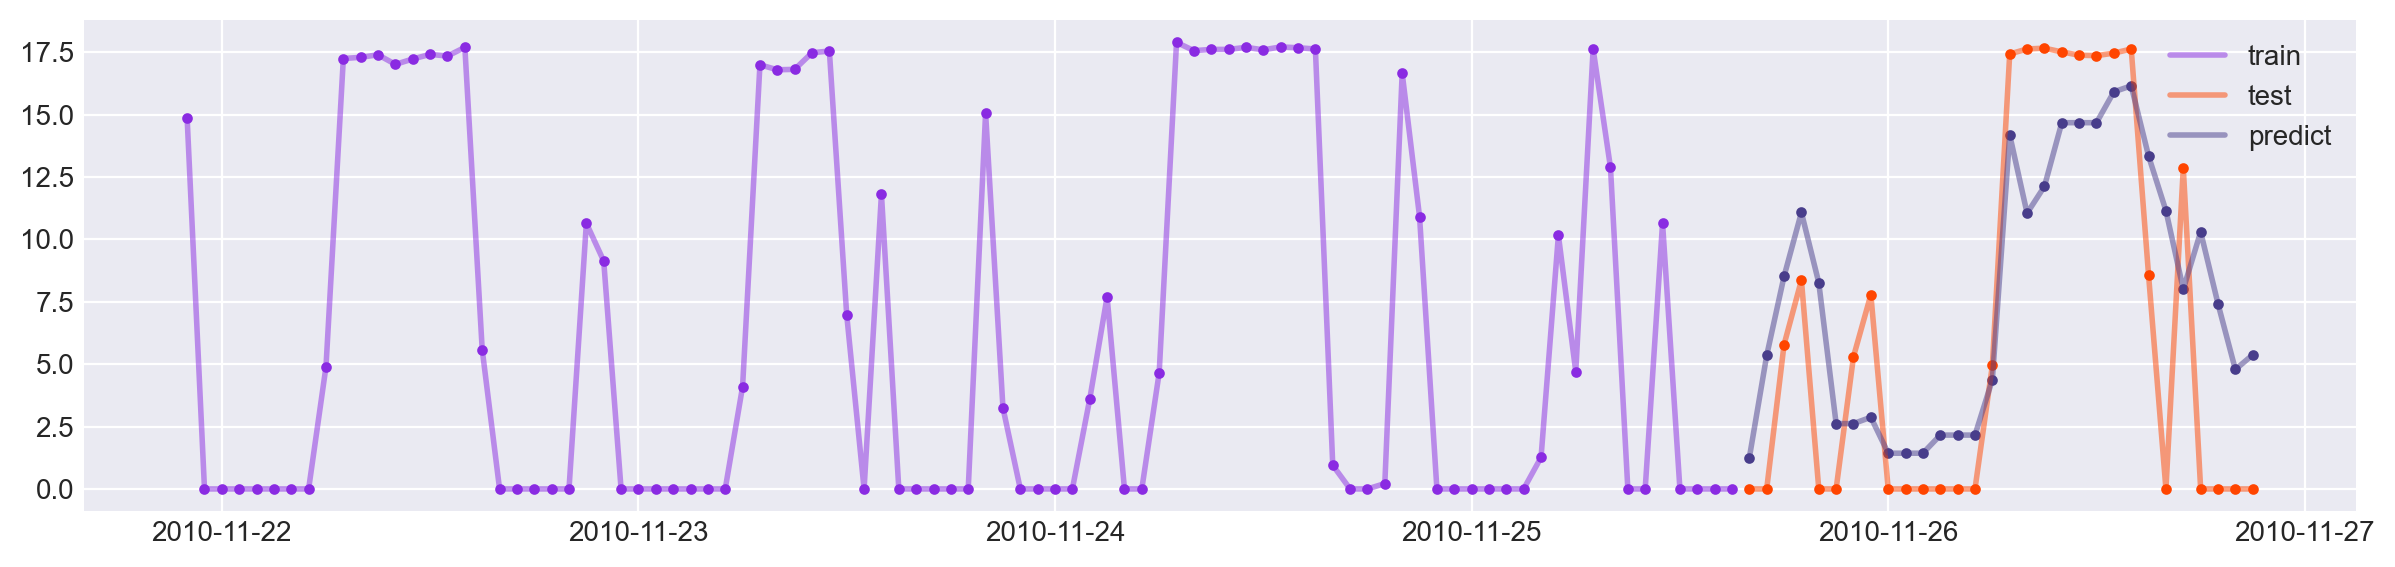

In [10]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [11]:
from sklearn.linear_model import BayesianRidge

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Convergence after  8  iterations


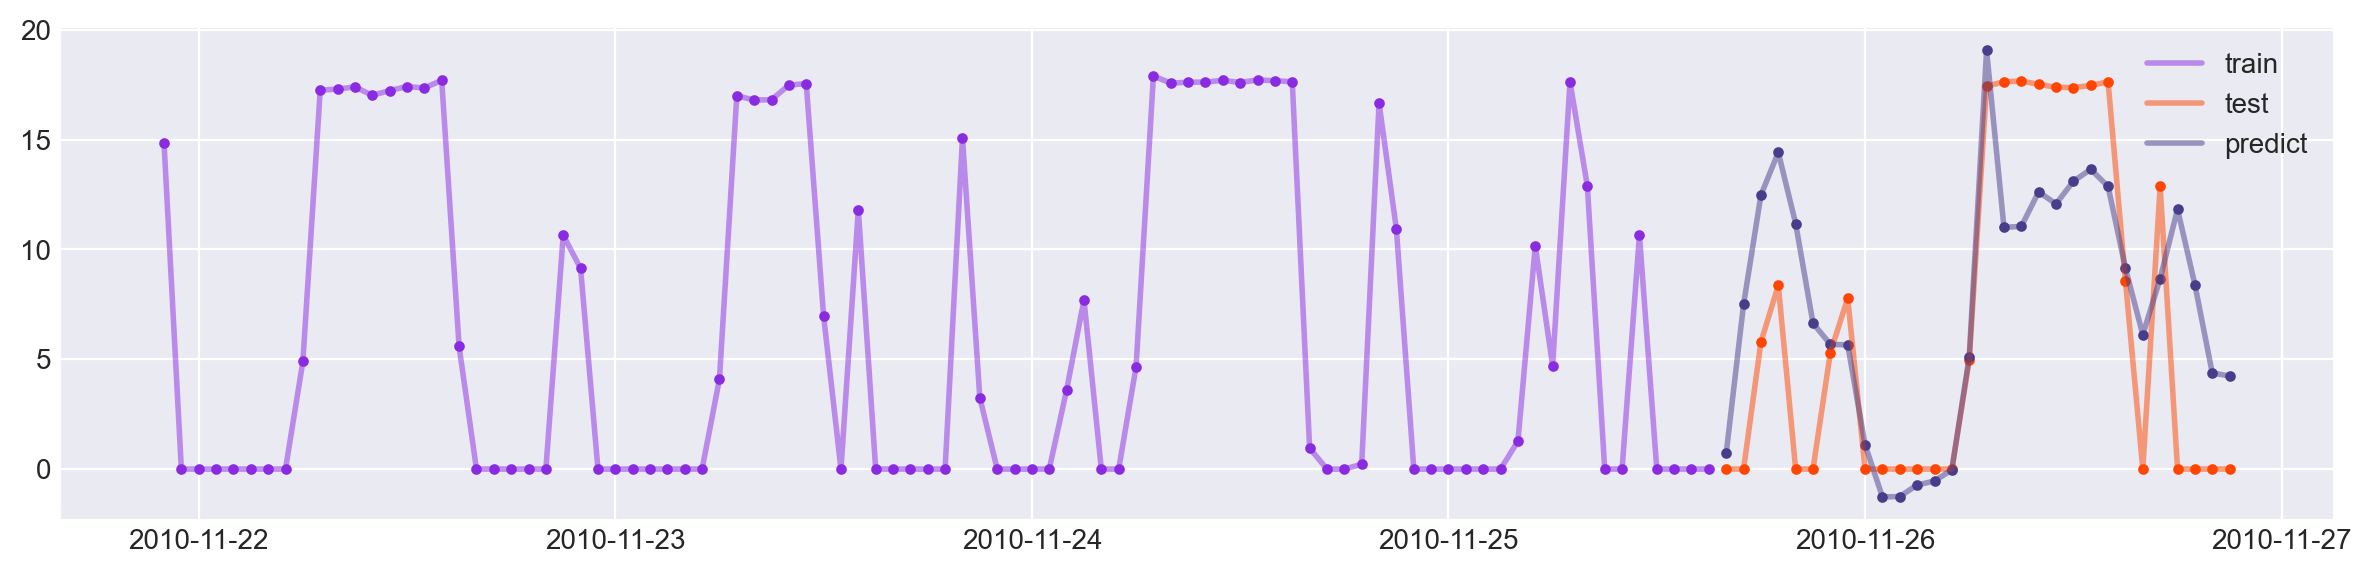

In [12]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [14]:
from sklearn.linear_model import LassoCV

model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("regressor", LassoCV(max_iter=10000, fit_intercept=True)),
    ]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

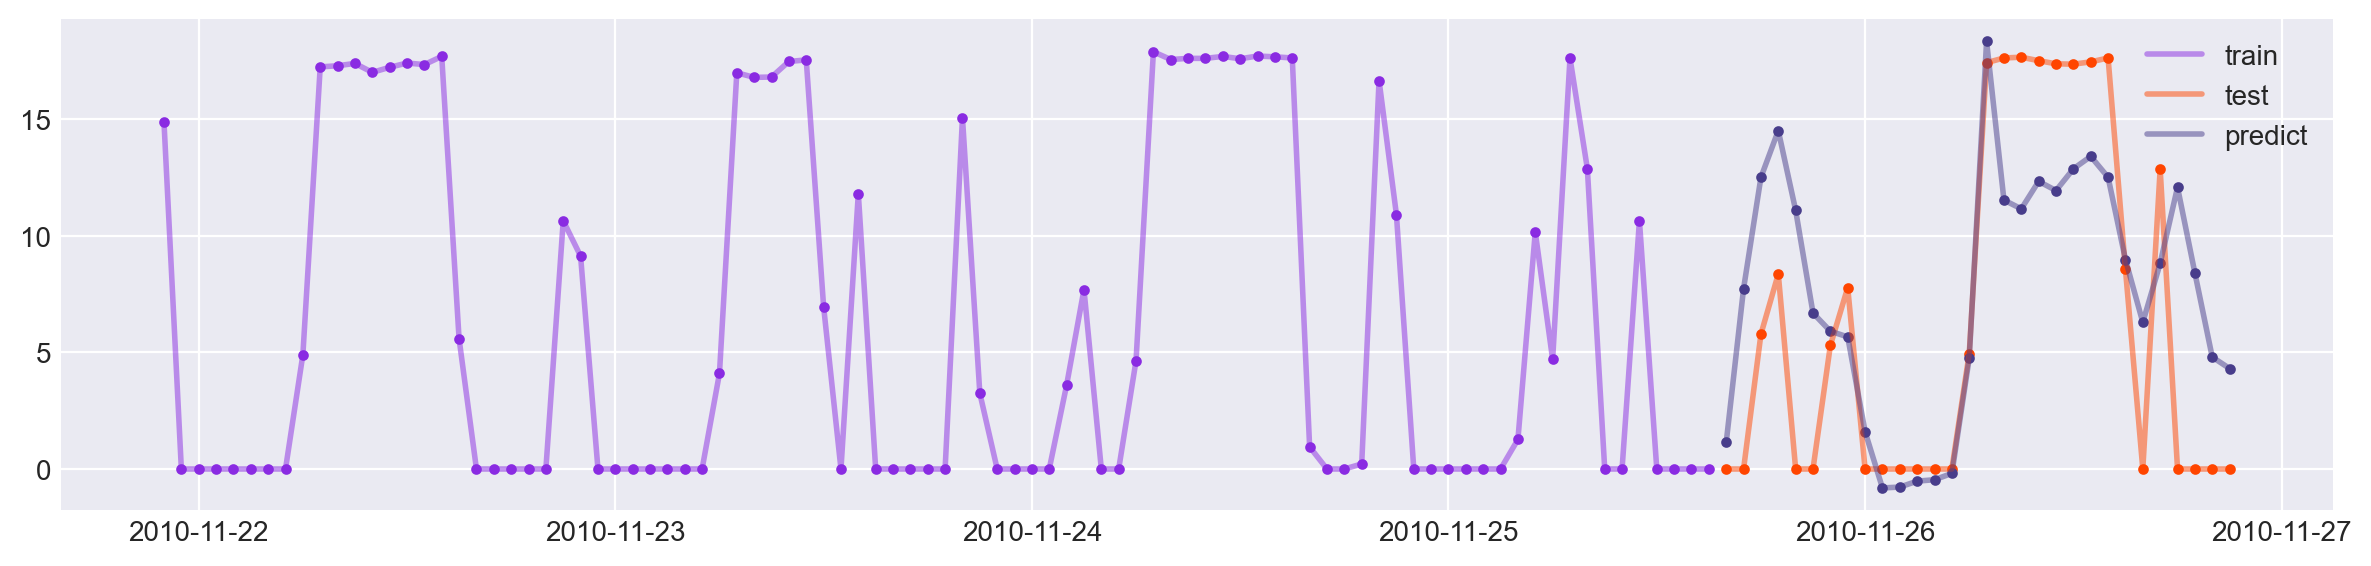

In [15]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [16]:
from sklearn.ensemble import RandomForestRegressor


model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

# best Params {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 600}

param_grid = {
    #'bootstrap': [True,False],
    # "max_depth": [7, 8, 9],
    # "min_samples_leaf": [2, 3],
    # "min_samples_split": [7, 8],
    # "n_estimators": [300, 500, 600],
    "max_depth": [9],
    "min_samples_leaf": [3],
    "min_samples_split": [7],
    "n_estimators": [600],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=600;, score=0.741 total time=   4.4s
[CV 2/3] END max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=600;, score=0.700 total time=   9.4s
[CV 3/3] END max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=600;, score=0.709 total time=  14.8s
0.7166827646883176 {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 600}


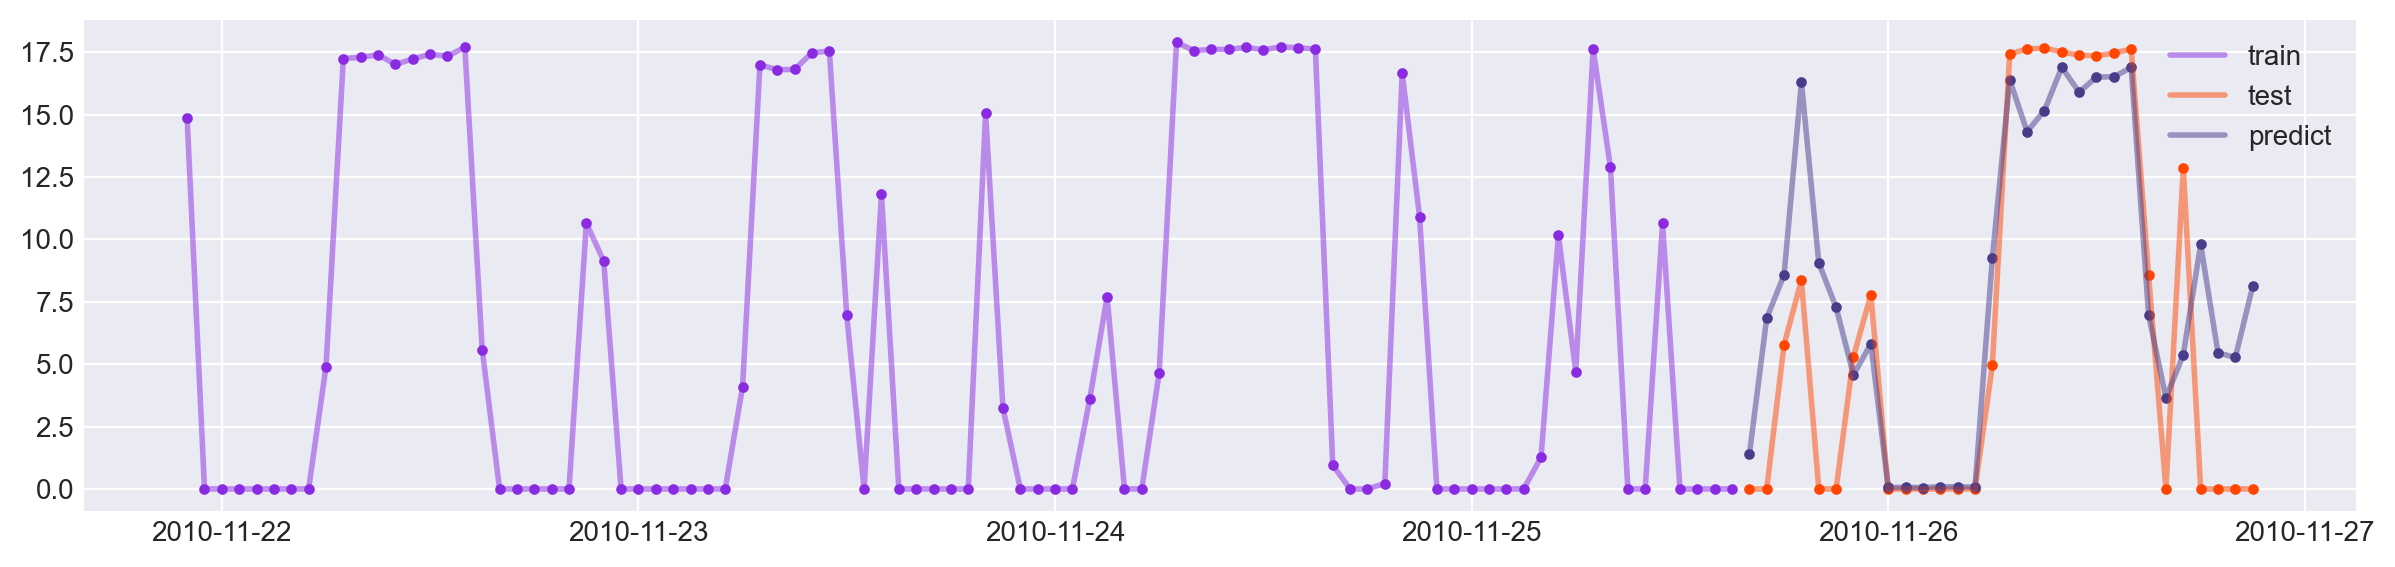

In [17]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

[0]	validation_0-mae:6.46864	validation_1-mae:6.40386
[1]	validation_0-mae:6.40797	validation_1-mae:6.35044
[2]	validation_0-mae:6.34872	validation_1-mae:6.29783
[3]	validation_0-mae:6.29097	validation_1-mae:6.25072
[4]	validation_0-mae:6.23465	validation_1-mae:6.19934
[5]	validation_0-mae:6.17904	validation_1-mae:6.15217
[6]	validation_0-mae:6.12451	validation_1-mae:6.10154
[7]	validation_0-mae:6.07065	validation_1-mae:6.05597
[8]	validation_0-mae:6.01695	validation_1-mae:6.00530
[9]	validation_0-mae:5.96470	validation_1-mae:5.96088
[10]	validation_0-mae:5.91375	validation_1-mae:5.91215
[11]	validation_0-mae:5.86227	validation_1-mae:5.86626
[12]	validation_0-mae:5.81210	validation_1-mae:5.82319
[13]	validation_0-mae:5.76279	validation_1-mae:5.78370
[14]	validation_0-mae:5.71421	validation_1-mae:5.73895
[15]	validation_0-mae:5.66625	validation_1-mae:5.69987
[16]	validation_0-mae:5.61899	validation_1-mae:5.65810
[17]	validation_0-mae:5.57240	validation_1-mae:5.61675
[18]	validation_0-ma

[148]	validation_0-mae:2.33351	validation_1-mae:3.41993
[149]	validation_0-mae:2.32154	validation_1-mae:3.41216
[150]	validation_0-mae:2.30970	validation_1-mae:3.40639
[151]	validation_0-mae:2.29854	validation_1-mae:3.40891
[152]	validation_0-mae:2.28705	validation_1-mae:3.40520
[153]	validation_0-mae:2.27568	validation_1-mae:3.39901
[154]	validation_0-mae:2.26487	validation_1-mae:3.39959
[155]	validation_0-mae:2.25359	validation_1-mae:3.39284
[156]	validation_0-mae:2.24257	validation_1-mae:3.38640
[157]	validation_0-mae:2.23163	validation_1-mae:3.38290
[158]	validation_0-mae:2.22133	validation_1-mae:3.38552
[159]	validation_0-mae:2.21055	validation_1-mae:3.38039
[160]	validation_0-mae:2.20024	validation_1-mae:3.38050
[161]	validation_0-mae:2.18969	validation_1-mae:3.37484
[162]	validation_0-mae:2.17968	validation_1-mae:3.36816
[163]	validation_0-mae:2.16960	validation_1-mae:3.36942
[164]	validation_0-mae:2.15941	validation_1-mae:3.37036
[165]	validation_0-mae:2.14950	validation_1-mae:

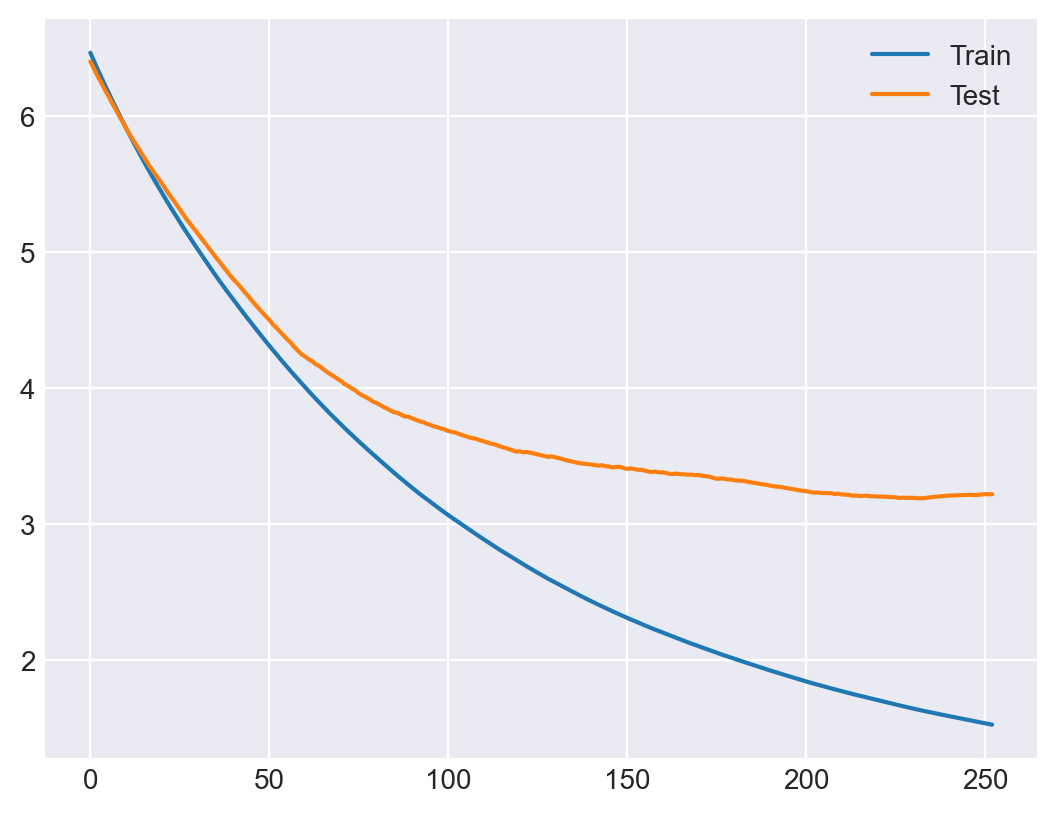

In [18]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

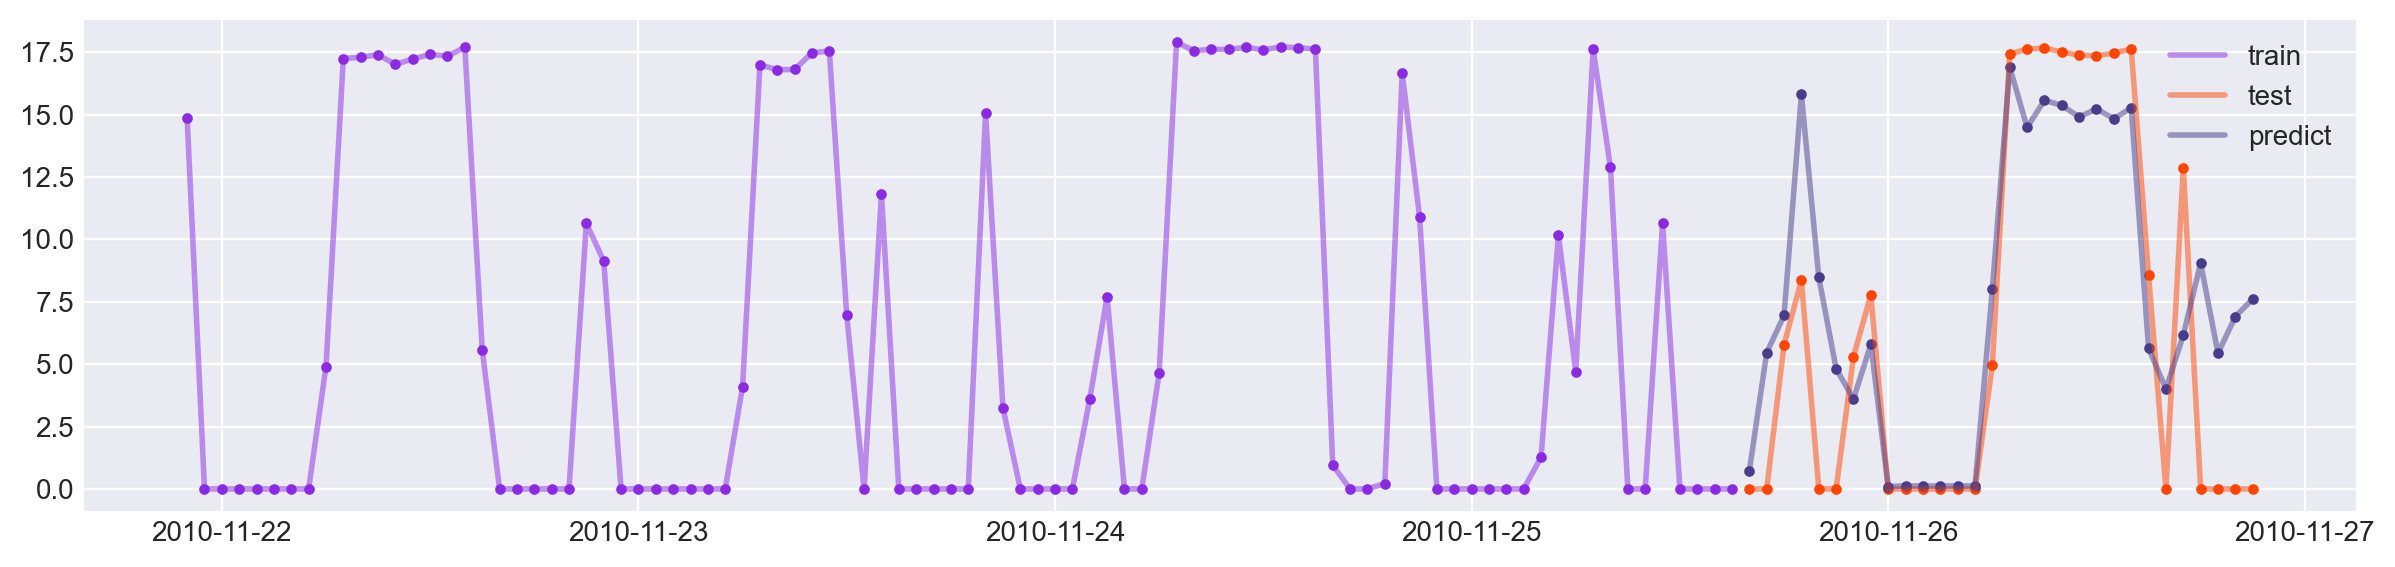

In [19]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [20]:
import lightgbm as lgb

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    callbacks=[lgb.early_stopping(stopping_rounds=5000), lgb.log_evaluation()],
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

[1]	training's l1: 5.99762	training's l2: 44.8657	valid_1's l1: 6.31764	valid_1's l2: 47.7017
Training until validation scores don't improve for 5000 rounds
[2]	training's l1: 5.5382	training's l2: 38.3531	valid_1's l1: 5.93977	valid_1's l2: 41.5382
[3]	training's l1: 5.12871	training's l2: 32.9767	valid_1's l1: 5.59562	valid_1's l2: 36.2302
[4]	training's l1: 4.76365	training's l2: 28.5929	valid_1's l1: 5.33552	valid_1's l2: 32.4544
[5]	training's l1: 4.44045	training's l2: 25.0116	valid_1's l1: 5.06754	valid_1's l2: 29.2342
[6]	training's l1: 4.14369	training's l2: 22.0369	valid_1's l1: 4.84744	valid_1's l2: 26.6069
[7]	training's l1: 3.87431	training's l2: 19.545	valid_1's l1: 4.64677	valid_1's l2: 24.6796
[8]	training's l1: 3.63599	training's l2: 17.5408	valid_1's l1: 4.4709	valid_1's l2: 23.0563
[9]	training's l1: 3.41382	training's l2: 15.7748	valid_1's l1: 4.31511	valid_1's l2: 21.9809
[10]	training's l1: 3.21711	training's l2: 14.3366	valid_1's l1: 4.17402	valid_1's l2: 20.9704

[96]	training's l1: 0.847751	training's l2: 1.59035	valid_1's l1: 3.40403	valid_1's l2: 22.4851
[97]	training's l1: 0.84264	training's l2: 1.56839	valid_1's l1: 3.39738	valid_1's l2: 22.4338
[98]	training's l1: 0.836251	training's l2: 1.5468	valid_1's l1: 3.41187	valid_1's l2: 22.6481
[99]	training's l1: 0.831238	training's l2: 1.52793	valid_1's l1: 3.41517	valid_1's l2: 22.6704
[100]	training's l1: 0.822183	training's l2: 1.49929	valid_1's l1: 3.41441	valid_1's l2: 22.6762
Did not meet early stopping. Best iteration is:
[100]	training's l1: 0.822183	training's l2: 1.49929	valid_1's l1: 3.41441	valid_1's l2: 22.6762


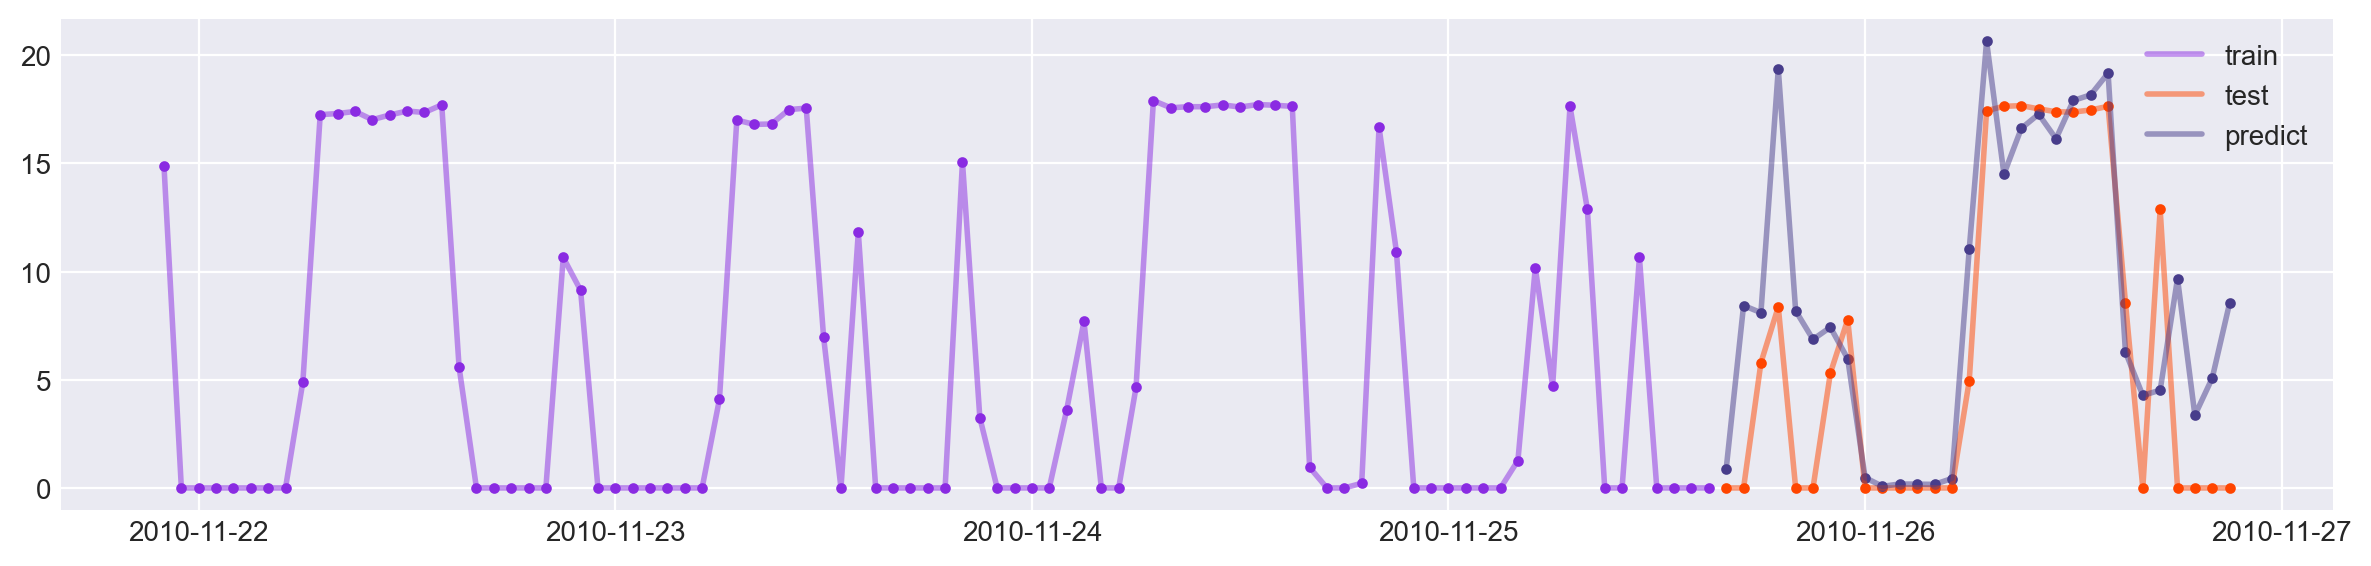

In [21]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [22]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=False
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

0:	learn: 9.3680658	test: 8.9332870	best: 8.9332870 (0)	total: 136ms	remaining: 2m 16s
1:	learn: 8.7073029	test: 8.2773703	best: 8.2773703 (1)	total: 137ms	remaining: 1m 8s
2:	learn: 8.0848809	test: 7.6408892	best: 7.6408892 (2)	total: 140ms	remaining: 46.6s
3:	learn: 7.5183937	test: 7.0898491	best: 7.0898491 (3)	total: 145ms	remaining: 36.2s
4:	learn: 7.0624178	test: 6.6349703	best: 6.6349703 (4)	total: 151ms	remaining: 30s
5:	learn: 6.6247955	test: 6.2396659	best: 6.2396659 (5)	total: 154ms	remaining: 25.5s
6:	learn: 6.2771364	test: 5.9373633	best: 5.9373633 (6)	total: 155ms	remaining: 22s
7:	learn: 5.9119415	test: 5.6688784	best: 5.6688784 (7)	total: 158ms	remaining: 19.6s
8:	learn: 5.6070404	test: 5.4135541	best: 5.4135541 (8)	total: 161ms	remaining: 17.7s
9:	learn: 5.3444102	test: 5.2226415	best: 5.2226415 (9)	total: 163ms	remaining: 16.2s
10:	learn: 5.1052492	test: 5.0184528	best: 5.0184528 (10)	total: 175ms	remaining: 15.7s
11:	learn: 4.9080199	test: 4.8735502	best: 4.8735502 (1

106:	learn: 2.8208590	test: 3.8859081	best: 3.8859081 (106)	total: 1.69s	remaining: 14.1s
107:	learn: 2.8102570	test: 3.8706789	best: 3.8706789 (107)	total: 1.71s	remaining: 14.1s
108:	learn: 2.8036714	test: 3.8682694	best: 3.8682694 (108)	total: 1.72s	remaining: 14s
109:	learn: 2.7978632	test: 3.8678848	best: 3.8678848 (109)	total: 1.76s	remaining: 14.3s
110:	learn: 2.7915975	test: 3.8702156	best: 3.8678848 (109)	total: 1.79s	remaining: 14.4s
111:	learn: 2.7833744	test: 3.8674892	best: 3.8674892 (111)	total: 1.82s	remaining: 14.5s
112:	learn: 2.7733055	test: 3.8692357	best: 3.8674892 (111)	total: 1.84s	remaining: 14.4s
113:	learn: 2.7649174	test: 3.8575649	best: 3.8575649 (113)	total: 1.85s	remaining: 14.4s
114:	learn: 2.7586092	test: 3.8592544	best: 3.8575649 (113)	total: 1.86s	remaining: 14.3s
115:	learn: 2.7543824	test: 3.8598898	best: 3.8575649 (113)	total: 1.87s	remaining: 14.3s
116:	learn: 2.7485366	test: 3.8561509	best: 3.8561509 (116)	total: 1.9s	remaining: 14.3s
117:	learn: 2

202:	learn: 2.3241642	test: 3.8679017	best: 3.8461843 (136)	total: 3.44s	remaining: 13.5s
203:	learn: 2.3231164	test: 3.8666996	best: 3.8461843 (136)	total: 3.47s	remaining: 13.5s
204:	learn: 2.3202825	test: 3.8651109	best: 3.8461843 (136)	total: 3.5s	remaining: 13.6s
205:	learn: 2.3136463	test: 3.8709976	best: 3.8461843 (136)	total: 3.52s	remaining: 13.6s
206:	learn: 2.3108093	test: 3.8710071	best: 3.8461843 (136)	total: 3.53s	remaining: 13.5s
207:	learn: 2.3068985	test: 3.8743998	best: 3.8461843 (136)	total: 3.54s	remaining: 13.5s
208:	learn: 2.3019110	test: 3.8802743	best: 3.8461843 (136)	total: 3.56s	remaining: 13.5s
209:	learn: 2.3000287	test: 3.8801686	best: 3.8461843 (136)	total: 3.57s	remaining: 13.4s
210:	learn: 2.2974619	test: 3.8825547	best: 3.8461843 (136)	total: 3.59s	remaining: 13.4s
211:	learn: 2.2930126	test: 3.8809555	best: 3.8461843 (136)	total: 3.61s	remaining: 13.4s
212:	learn: 2.2891718	test: 3.8836345	best: 3.8461843 (136)	total: 3.62s	remaining: 13.4s
213:	learn:

296:	learn: 2.0326192	test: 3.9512092	best: 3.8461843 (136)	total: 4.97s	remaining: 11.8s
297:	learn: 2.0301840	test: 3.9516870	best: 3.8461843 (136)	total: 5s	remaining: 11.8s
298:	learn: 2.0278346	test: 3.9492783	best: 3.8461843 (136)	total: 5.01s	remaining: 11.8s
299:	learn: 2.0235865	test: 3.9476946	best: 3.8461843 (136)	total: 5.03s	remaining: 11.7s
300:	learn: 2.0212708	test: 3.9440274	best: 3.8461843 (136)	total: 5.04s	remaining: 11.7s
301:	learn: 2.0200254	test: 3.9438522	best: 3.8461843 (136)	total: 5.05s	remaining: 11.7s
302:	learn: 2.0168825	test: 3.9439636	best: 3.8461843 (136)	total: 5.07s	remaining: 11.7s
303:	learn: 2.0140923	test: 3.9437347	best: 3.8461843 (136)	total: 5.1s	remaining: 11.7s
304:	learn: 2.0092386	test: 3.9425019	best: 3.8461843 (136)	total: 5.13s	remaining: 11.7s
305:	learn: 2.0047443	test: 3.9503307	best: 3.8461843 (136)	total: 5.15s	remaining: 11.7s
306:	learn: 2.0026968	test: 3.9528457	best: 3.8461843 (136)	total: 5.16s	remaining: 11.6s
307:	learn: 2.

396:	learn: 1.7822194	test: 4.0105225	best: 3.8461843 (136)	total: 6.46s	remaining: 9.82s
397:	learn: 1.7789711	test: 4.0156675	best: 3.8461843 (136)	total: 6.49s	remaining: 9.81s
398:	learn: 1.7764458	test: 4.0153996	best: 3.8461843 (136)	total: 6.51s	remaining: 9.81s
399:	learn: 1.7740234	test: 4.0155957	best: 3.8461843 (136)	total: 6.53s	remaining: 9.79s
400:	learn: 1.7723101	test: 4.0147204	best: 3.8461843 (136)	total: 6.54s	remaining: 9.77s
401:	learn: 1.7706138	test: 4.0148339	best: 3.8461843 (136)	total: 6.55s	remaining: 9.74s
402:	learn: 1.7671481	test: 4.0125222	best: 3.8461843 (136)	total: 6.56s	remaining: 9.72s
403:	learn: 1.7652396	test: 4.0130383	best: 3.8461843 (136)	total: 6.58s	remaining: 9.71s
404:	learn: 1.7638572	test: 4.0284143	best: 3.8461843 (136)	total: 6.6s	remaining: 9.7s
405:	learn: 1.7621650	test: 4.0279535	best: 3.8461843 (136)	total: 6.62s	remaining: 9.68s
406:	learn: 1.7607139	test: 4.0284974	best: 3.8461843 (136)	total: 6.63s	remaining: 9.67s
407:	learn: 

492:	learn: 1.5785354	test: 4.0457979	best: 3.8461843 (136)	total: 7.95s	remaining: 8.17s
493:	learn: 1.5782046	test: 4.0453049	best: 3.8461843 (136)	total: 7.97s	remaining: 8.16s
494:	learn: 1.5766631	test: 4.0579574	best: 3.8461843 (136)	total: 7.98s	remaining: 8.14s
495:	learn: 1.5746113	test: 4.0578508	best: 3.8461843 (136)	total: 7.99s	remaining: 8.12s
496:	learn: 1.5718483	test: 4.0736207	best: 3.8461843 (136)	total: 8.01s	remaining: 8.1s
497:	learn: 1.5701115	test: 4.0736833	best: 3.8461843 (136)	total: 8.02s	remaining: 8.08s
498:	learn: 1.5693495	test: 4.0731070	best: 3.8461843 (136)	total: 8.05s	remaining: 8.08s
499:	learn: 1.5671965	test: 4.0740091	best: 3.8461843 (136)	total: 8.07s	remaining: 8.07s
500:	learn: 1.5653787	test: 4.0750727	best: 3.8461843 (136)	total: 8.1s	remaining: 8.07s
501:	learn: 1.5631045	test: 4.0739040	best: 3.8461843 (136)	total: 8.12s	remaining: 8.05s
502:	learn: 1.5605379	test: 4.0755896	best: 3.8461843 (136)	total: 8.13s	remaining: 8.04s
503:	learn: 

614:	learn: 1.3723770	test: 4.0931256	best: 3.8461843 (136)	total: 9.66s	remaining: 6.04s
615:	learn: 1.3717253	test: 4.0936876	best: 3.8461843 (136)	total: 9.69s	remaining: 6.04s
616:	learn: 1.3692053	test: 4.0934072	best: 3.8461843 (136)	total: 9.72s	remaining: 6.03s
617:	learn: 1.3678162	test: 4.1075111	best: 3.8461843 (136)	total: 9.74s	remaining: 6.02s
618:	learn: 1.3657743	test: 4.1079931	best: 3.8461843 (136)	total: 9.75s	remaining: 6s
619:	learn: 1.3638147	test: 4.1084990	best: 3.8461843 (136)	total: 9.77s	remaining: 5.99s
620:	learn: 1.3624272	test: 4.1092823	best: 3.8461843 (136)	total: 9.78s	remaining: 5.97s
621:	learn: 1.3604024	test: 4.1103760	best: 3.8461843 (136)	total: 9.79s	remaining: 5.95s
622:	learn: 1.3589120	test: 4.1126708	best: 3.8461843 (136)	total: 9.82s	remaining: 5.94s
623:	learn: 1.3565386	test: 4.1126282	best: 3.8461843 (136)	total: 9.85s	remaining: 5.93s
624:	learn: 1.3546984	test: 4.1130866	best: 3.8461843 (136)	total: 9.88s	remaining: 5.93s
625:	learn: 1

716:	learn: 1.2366999	test: 4.1184855	best: 3.8461843 (136)	total: 11.4s	remaining: 4.51s
717:	learn: 1.2351123	test: 4.1178297	best: 3.8461843 (136)	total: 11.4s	remaining: 4.5s
718:	learn: 1.2330048	test: 4.1174832	best: 3.8461843 (136)	total: 11.5s	remaining: 4.48s
719:	learn: 1.2323462	test: 4.1180031	best: 3.8461843 (136)	total: 11.5s	remaining: 4.46s
720:	learn: 1.2319201	test: 4.1177111	best: 3.8461843 (136)	total: 11.5s	remaining: 4.45s
721:	learn: 1.2304276	test: 4.1190010	best: 3.8461843 (136)	total: 11.5s	remaining: 4.43s
722:	learn: 1.2295391	test: 4.1188474	best: 3.8461843 (136)	total: 11.5s	remaining: 4.41s
723:	learn: 1.2291396	test: 4.1189964	best: 3.8461843 (136)	total: 11.5s	remaining: 4.4s
724:	learn: 1.2279604	test: 4.1174762	best: 3.8461843 (136)	total: 11.6s	remaining: 4.39s
725:	learn: 1.2260888	test: 4.1178406	best: 3.8461843 (136)	total: 11.6s	remaining: 4.38s
726:	learn: 1.2252639	test: 4.1180214	best: 3.8461843 (136)	total: 11.6s	remaining: 4.36s
727:	learn: 

810:	learn: 1.1368673	test: 4.1104666	best: 3.8461843 (136)	total: 12.7s	remaining: 2.96s
811:	learn: 1.1361296	test: 4.1110042	best: 3.8461843 (136)	total: 12.7s	remaining: 2.94s
812:	learn: 1.1350658	test: 4.1112212	best: 3.8461843 (136)	total: 12.7s	remaining: 2.93s
813:	learn: 1.1342399	test: 4.1112330	best: 3.8461843 (136)	total: 12.8s	remaining: 2.92s
814:	learn: 1.1334139	test: 4.1113438	best: 3.8461843 (136)	total: 12.8s	remaining: 2.9s
815:	learn: 1.1325374	test: 4.1113766	best: 3.8461843 (136)	total: 12.8s	remaining: 2.89s
816:	learn: 1.1320380	test: 4.1121479	best: 3.8461843 (136)	total: 12.8s	remaining: 2.87s
817:	learn: 1.1304940	test: 4.1120416	best: 3.8461843 (136)	total: 12.8s	remaining: 2.86s
818:	learn: 1.1299688	test: 4.1125150	best: 3.8461843 (136)	total: 12.9s	remaining: 2.84s
819:	learn: 1.1291877	test: 4.1115095	best: 3.8461843 (136)	total: 12.9s	remaining: 2.83s
820:	learn: 1.1263405	test: 4.1124365	best: 3.8461843 (136)	total: 12.9s	remaining: 2.81s
821:	learn:

903:	learn: 1.0509025	test: 4.1534345	best: 3.8461843 (136)	total: 14.2s	remaining: 1.51s
904:	learn: 1.0506600	test: 4.1535749	best: 3.8461843 (136)	total: 14.3s	remaining: 1.5s
905:	learn: 1.0496379	test: 4.1530718	best: 3.8461843 (136)	total: 14.3s	remaining: 1.48s
906:	learn: 1.0487544	test: 4.1528259	best: 3.8461843 (136)	total: 14.3s	remaining: 1.47s
907:	learn: 1.0480653	test: 4.1532708	best: 3.8461843 (136)	total: 14.3s	remaining: 1.45s
908:	learn: 1.0466089	test: 4.1523918	best: 3.8461843 (136)	total: 14.3s	remaining: 1.43s
909:	learn: 1.0461802	test: 4.1523150	best: 3.8461843 (136)	total: 14.4s	remaining: 1.42s
910:	learn: 1.0445501	test: 4.1519369	best: 3.8461843 (136)	total: 14.4s	remaining: 1.4s
911:	learn: 1.0433577	test: 4.1528059	best: 3.8461843 (136)	total: 14.4s	remaining: 1.39s
912:	learn: 1.0422105	test: 4.1530491	best: 3.8461843 (136)	total: 14.4s	remaining: 1.37s
913:	learn: 1.0409998	test: 4.1542258	best: 3.8461843 (136)	total: 14.4s	remaining: 1.36s
914:	learn: 

997:	learn: 0.9741535	test: 4.1722753	best: 3.8461843 (136)	total: 15.8s	remaining: 31.6ms
998:	learn: 0.9737252	test: 4.1726218	best: 3.8461843 (136)	total: 15.8s	remaining: 15.8ms
999:	learn: 0.9729357	test: 4.1727335	best: 3.8461843 (136)	total: 15.8s	remaining: 0us

bestTest = 3.846184349
bestIteration = 136

0:	loss: 3.8461843	best: 3.8461843 (0)	total: 16s	remaining: 16s
0:	learn: 9.3858085	test: 8.9646239	best: 8.9646239 (0)	total: 12.5ms	remaining: 12.5s
1:	learn: 8.7250099	test: 8.3084937	best: 8.3084937 (1)	total: 19.3ms	remaining: 9.64s
2:	learn: 8.1114232	test: 7.6787747	best: 7.6787747 (2)	total: 29.9ms	remaining: 9.93s
3:	learn: 7.5545239	test: 7.1391592	best: 7.1391592 (3)	total: 40.6ms	remaining: 10.1s
4:	learn: 7.0999910	test: 6.6828778	best: 6.6828778 (4)	total: 67.6ms	remaining: 13.5s
5:	learn: 6.6627520	test: 6.2866278	best: 6.2866278 (5)	total: 96.4ms	remaining: 16s
6:	learn: 6.3115981	test: 5.9802176	best: 5.9802176 (6)	total: 113ms	remaining: 16.1s
7:	learn: 5.94

115:	learn: 2.8424290	test: 3.8193987	best: 3.8153145 (110)	total: 1.27s	remaining: 9.7s
116:	learn: 2.8366416	test: 3.8233828	best: 3.8153145 (110)	total: 1.27s	remaining: 9.62s
117:	learn: 2.8327721	test: 3.8239114	best: 3.8153145 (110)	total: 1.27s	remaining: 9.54s
118:	learn: 2.8263658	test: 3.8243749	best: 3.8153145 (110)	total: 1.28s	remaining: 9.46s
119:	learn: 2.8204444	test: 3.8212738	best: 3.8153145 (110)	total: 1.28s	remaining: 9.38s
120:	learn: 2.8152385	test: 3.8206944	best: 3.8153145 (110)	total: 1.29s	remaining: 9.41s
121:	learn: 2.8081630	test: 3.8161178	best: 3.8153145 (110)	total: 1.32s	remaining: 9.53s
122:	learn: 2.8016145	test: 3.8121308	best: 3.8121308 (122)	total: 1.35s	remaining: 9.64s
123:	learn: 2.7989715	test: 3.8171002	best: 3.8121308 (122)	total: 1.38s	remaining: 9.72s
124:	learn: 2.7940535	test: 3.8190315	best: 3.8121308 (122)	total: 1.39s	remaining: 9.72s
125:	learn: 2.7884976	test: 3.8156250	best: 3.8121308 (122)	total: 1.4s	remaining: 9.73s
126:	learn: 

215:	learn: 2.4029896	test: 3.8607045	best: 3.8036925 (144)	total: 2.61s	remaining: 9.49s
216:	learn: 2.3988712	test: 3.8602162	best: 3.8036925 (144)	total: 2.64s	remaining: 9.53s
217:	learn: 2.3957839	test: 3.8597640	best: 3.8036925 (144)	total: 2.65s	remaining: 9.52s
218:	learn: 2.3874191	test: 3.8596944	best: 3.8036925 (144)	total: 2.67s	remaining: 9.52s
219:	learn: 2.3839544	test: 3.8606849	best: 3.8036925 (144)	total: 2.68s	remaining: 9.52s
220:	learn: 2.3813346	test: 3.8603632	best: 3.8036925 (144)	total: 2.7s	remaining: 9.52s
221:	learn: 2.3785062	test: 3.8581688	best: 3.8036925 (144)	total: 2.73s	remaining: 9.55s
222:	learn: 2.3766579	test: 3.8578104	best: 3.8036925 (144)	total: 2.75s	remaining: 9.6s
223:	learn: 2.3743200	test: 3.8571805	best: 3.8036925 (144)	total: 2.79s	remaining: 9.66s
224:	learn: 2.3700731	test: 3.8588917	best: 3.8036925 (144)	total: 2.8s	remaining: 9.66s
225:	learn: 2.3688511	test: 3.8607243	best: 3.8036925 (144)	total: 2.82s	remaining: 9.66s
226:	learn: 2

310:	learn: 2.1097030	test: 3.8872510	best: 3.8036925 (144)	total: 4.09s	remaining: 9.07s
311:	learn: 2.1067877	test: 3.8885407	best: 3.8036925 (144)	total: 4.12s	remaining: 9.07s
312:	learn: 2.1015108	test: 3.8887074	best: 3.8036925 (144)	total: 4.13s	remaining: 9.06s
313:	learn: 2.0979111	test: 3.8905855	best: 3.8036925 (144)	total: 4.14s	remaining: 9.04s
314:	learn: 2.0967599	test: 3.8898299	best: 3.8036925 (144)	total: 4.15s	remaining: 9.02s
315:	learn: 2.0920201	test: 3.8915142	best: 3.8036925 (144)	total: 4.16s	remaining: 9s
316:	learn: 2.0887048	test: 3.8922087	best: 3.8036925 (144)	total: 4.18s	remaining: 9.02s
317:	learn: 2.0858606	test: 3.8914990	best: 3.8036925 (144)	total: 4.21s	remaining: 9.03s
318:	learn: 2.0831718	test: 3.9031056	best: 3.8036925 (144)	total: 4.24s	remaining: 9.04s
319:	learn: 2.0805576	test: 3.9014738	best: 3.8036925 (144)	total: 4.26s	remaining: 9.05s
320:	learn: 2.0778677	test: 3.9015590	best: 3.8036925 (144)	total: 4.29s	remaining: 9.07s
321:	learn: 2

403:	learn: 1.9008998	test: 3.9060618	best: 3.8036925 (144)	total: 5.38s	remaining: 7.94s
404:	learn: 1.8993929	test: 3.9058871	best: 3.8036925 (144)	total: 5.38s	remaining: 7.91s
405:	learn: 1.8960870	test: 3.9020789	best: 3.8036925 (144)	total: 5.38s	remaining: 7.88s
406:	learn: 1.8924861	test: 3.9026712	best: 3.8036925 (144)	total: 5.4s	remaining: 7.87s
407:	learn: 1.8900517	test: 3.9027124	best: 3.8036925 (144)	total: 5.41s	remaining: 7.85s
408:	learn: 1.8891760	test: 3.9022872	best: 3.8036925 (144)	total: 5.42s	remaining: 7.83s
409:	learn: 1.8874047	test: 3.8993420	best: 3.8036925 (144)	total: 5.43s	remaining: 7.82s
410:	learn: 1.8850071	test: 3.8993453	best: 3.8036925 (144)	total: 5.49s	remaining: 7.87s
411:	learn: 1.8832586	test: 3.9001657	best: 3.8036925 (144)	total: 5.52s	remaining: 7.88s
412:	learn: 1.8791180	test: 3.9009706	best: 3.8036925 (144)	total: 5.54s	remaining: 7.87s
413:	learn: 1.8789324	test: 3.9008412	best: 3.8036925 (144)	total: 5.55s	remaining: 7.86s
414:	learn:

500:	learn: 1.7050586	test: 3.9666716	best: 3.8036925 (144)	total: 6.9s	remaining: 6.87s
501:	learn: 1.7040909	test: 3.9649024	best: 3.8036925 (144)	total: 6.9s	remaining: 6.84s
502:	learn: 1.7024115	test: 3.9646123	best: 3.8036925 (144)	total: 6.9s	remaining: 6.82s
503:	learn: 1.7012851	test: 3.9645860	best: 3.8036925 (144)	total: 6.9s	remaining: 6.79s
504:	learn: 1.7000412	test: 3.9641540	best: 3.8036925 (144)	total: 6.91s	remaining: 6.77s
505:	learn: 1.6972663	test: 3.9661344	best: 3.8036925 (144)	total: 6.91s	remaining: 6.75s
506:	learn: 1.6946388	test: 3.9657107	best: 3.8036925 (144)	total: 6.91s	remaining: 6.72s
507:	learn: 1.6916315	test: 3.9704710	best: 3.8036925 (144)	total: 6.92s	remaining: 6.7s
508:	learn: 1.6896745	test: 3.9714858	best: 3.8036925 (144)	total: 6.93s	remaining: 6.69s
509:	learn: 1.6880014	test: 3.9730770	best: 3.8036925 (144)	total: 6.96s	remaining: 6.69s
510:	learn: 1.6873462	test: 3.9734071	best: 3.8036925 (144)	total: 6.99s	remaining: 6.69s
511:	learn: 1.6

598:	learn: 1.5391872	test: 3.9945472	best: 3.8036925 (144)	total: 8.63s	remaining: 5.78s
599:	learn: 1.5378198	test: 3.9939999	best: 3.8036925 (144)	total: 8.64s	remaining: 5.76s
600:	learn: 1.5366535	test: 3.9925261	best: 3.8036925 (144)	total: 8.66s	remaining: 5.75s
601:	learn: 1.5356121	test: 3.9915897	best: 3.8036925 (144)	total: 8.66s	remaining: 5.73s
602:	learn: 1.5345271	test: 3.9913607	best: 3.8036925 (144)	total: 8.69s	remaining: 5.72s
603:	learn: 1.5329123	test: 3.9907938	best: 3.8036925 (144)	total: 8.72s	remaining: 5.72s
604:	learn: 1.5319412	test: 3.9910767	best: 3.8036925 (144)	total: 8.75s	remaining: 5.71s
605:	learn: 1.5311697	test: 3.9882997	best: 3.8036925 (144)	total: 8.77s	remaining: 5.7s
606:	learn: 1.5289425	test: 3.9872236	best: 3.8036925 (144)	total: 8.79s	remaining: 5.69s
607:	learn: 1.5269006	test: 3.9864957	best: 3.8036925 (144)	total: 8.81s	remaining: 5.68s
608:	learn: 1.5254491	test: 3.9887516	best: 3.8036925 (144)	total: 8.82s	remaining: 5.67s
609:	learn:

699:	learn: 1.4016380	test: 4.0364456	best: 3.8036925 (144)	total: 10.3s	remaining: 4.43s
700:	learn: 1.4006656	test: 4.0373705	best: 3.8036925 (144)	total: 10.4s	remaining: 4.42s
701:	learn: 1.3991523	test: 4.0379208	best: 3.8036925 (144)	total: 10.4s	remaining: 4.39s
702:	learn: 1.3980350	test: 4.0382952	best: 3.8036925 (144)	total: 10.4s	remaining: 4.38s
703:	learn: 1.3967854	test: 4.0383226	best: 3.8036925 (144)	total: 10.4s	remaining: 4.36s
704:	learn: 1.3953335	test: 4.0385612	best: 3.8036925 (144)	total: 10.4s	remaining: 4.34s
705:	learn: 1.3950150	test: 4.0385524	best: 3.8036925 (144)	total: 10.4s	remaining: 4.32s
706:	learn: 1.3931329	test: 4.0398251	best: 3.8036925 (144)	total: 10.4s	remaining: 4.3s
707:	learn: 1.3923248	test: 4.0426852	best: 3.8036925 (144)	total: 10.4s	remaining: 4.29s
708:	learn: 1.3903065	test: 4.0433042	best: 3.8036925 (144)	total: 10.4s	remaining: 4.28s
709:	learn: 1.3886316	test: 4.0433806	best: 3.8036925 (144)	total: 10.4s	remaining: 4.27s
710:	learn:

805:	learn: 1.2813623	test: 4.0933295	best: 3.8036925 (144)	total: 12.1s	remaining: 2.9s
806:	learn: 1.2805685	test: 4.0936919	best: 3.8036925 (144)	total: 12.1s	remaining: 2.89s
807:	learn: 1.2786813	test: 4.0929765	best: 3.8036925 (144)	total: 12.1s	remaining: 2.88s
808:	learn: 1.2783513	test: 4.0931206	best: 3.8036925 (144)	total: 12.1s	remaining: 2.86s
809:	learn: 1.2768153	test: 4.0934115	best: 3.8036925 (144)	total: 12.1s	remaining: 2.85s
810:	learn: 1.2746560	test: 4.0920862	best: 3.8036925 (144)	total: 12.2s	remaining: 2.83s
811:	learn: 1.2740831	test: 4.0918381	best: 3.8036925 (144)	total: 12.2s	remaining: 2.82s
812:	learn: 1.2728741	test: 4.0914709	best: 3.8036925 (144)	total: 12.2s	remaining: 2.8s
813:	learn: 1.2711399	test: 4.0917057	best: 3.8036925 (144)	total: 12.2s	remaining: 2.79s
814:	learn: 1.2699974	test: 4.0901660	best: 3.8036925 (144)	total: 12.2s	remaining: 2.77s
815:	learn: 1.2693038	test: 4.0905255	best: 3.8036925 (144)	total: 12.2s	remaining: 2.76s
816:	learn: 

902:	learn: 1.1821151	test: 4.1114662	best: 3.8036925 (144)	total: 13.8s	remaining: 1.48s
903:	learn: 1.1796259	test: 4.1111549	best: 3.8036925 (144)	total: 13.8s	remaining: 1.47s
904:	learn: 1.1784184	test: 4.1104839	best: 3.8036925 (144)	total: 13.8s	remaining: 1.45s
905:	learn: 1.1779432	test: 4.1092402	best: 3.8036925 (144)	total: 13.8s	remaining: 1.43s
906:	learn: 1.1764063	test: 4.1089630	best: 3.8036925 (144)	total: 13.8s	remaining: 1.42s
907:	learn: 1.1757348	test: 4.1086111	best: 3.8036925 (144)	total: 13.8s	remaining: 1.4s
908:	learn: 1.1752380	test: 4.1084620	best: 3.8036925 (144)	total: 13.8s	remaining: 1.38s
909:	learn: 1.1746623	test: 4.1094219	best: 3.8036925 (144)	total: 13.8s	remaining: 1.37s
910:	learn: 1.1742776	test: 4.1094431	best: 3.8036925 (144)	total: 13.8s	remaining: 1.35s
911:	learn: 1.1734000	test: 4.1087844	best: 3.8036925 (144)	total: 13.9s	remaining: 1.34s
912:	learn: 1.1722124	test: 4.1089180	best: 3.8036925 (144)	total: 13.9s	remaining: 1.32s
913:	learn:

996:	learn: 1.0980686	test: 4.1179141	best: 3.8036925 (144)	total: 15.1s	remaining: 45.4ms
997:	learn: 1.0966958	test: 4.1182765	best: 3.8036925 (144)	total: 15.1s	remaining: 30.2ms
998:	learn: 1.0960361	test: 4.1190132	best: 3.8036925 (144)	total: 15.1s	remaining: 15.1ms
999:	learn: 1.0950915	test: 4.1292968	best: 3.8036925 (144)	total: 15.1s	remaining: 0us

bestTest = 3.803692458
bestIteration = 144

1:	loss: 3.8036925	best: 3.8036925 (1)	total: 31.2s	remaining: 0us
Estimating final quality...
Training on fold [0/3]
0:	learn: 9.4159669	test: 9.2653607	best: 9.2653607 (0)	total: 16.8ms	remaining: 16.8s
1:	learn: 8.7802950	test: 8.6292098	best: 8.6292098 (1)	total: 27.7ms	remaining: 13.8s
2:	learn: 8.1715718	test: 8.1052843	best: 8.1052843 (2)	total: 38.3ms	remaining: 12.7s
3:	learn: 7.6267407	test: 7.6037587	best: 7.6037587 (3)	total: 50.3ms	remaining: 12.5s
4:	learn: 7.1508310	test: 7.1920903	best: 7.1920903 (4)	total: 78.7ms	remaining: 15.7s
5:	learn: 6.7254296	test: 6.7930787	best:

99:	learn: 3.0129339	test: 3.4234029	best: 3.4234029 (99)	total: 1.58s	remaining: 14.3s
100:	learn: 3.0079896	test: 3.4246964	best: 3.4234029 (99)	total: 1.59s	remaining: 14.1s
101:	learn: 2.9975199	test: 3.4081249	best: 3.4081249 (101)	total: 1.59s	remaining: 14s
102:	learn: 2.9964104	test: 3.4080353	best: 3.4080353 (102)	total: 1.6s	remaining: 13.9s
103:	learn: 2.9945536	test: 3.4079865	best: 3.4079865 (103)	total: 1.6s	remaining: 13.8s
104:	learn: 2.9927701	test: 3.4076573	best: 3.4076573 (104)	total: 1.62s	remaining: 13.8s
105:	learn: 2.9917746	test: 3.4075017	best: 3.4075017 (105)	total: 1.64s	remaining: 13.9s
106:	learn: 2.9881821	test: 3.4073540	best: 3.4073540 (106)	total: 1.67s	remaining: 14s
107:	learn: 2.9861109	test: 3.4073923	best: 3.4073540 (106)	total: 1.69s	remaining: 14s
108:	learn: 2.9852497	test: 3.4073669	best: 3.4073540 (106)	total: 1.7s	remaining: 13.9s
109:	learn: 2.9842850	test: 3.4073492	best: 3.4073492 (109)	total: 1.72s	remaining: 13.9s
110:	learn: 2.9802541	

195:	learn: 2.6153661	test: 3.4064149	best: 3.3781718 (145)	total: 3.08s	remaining: 12.6s
196:	learn: 2.6133084	test: 3.4059529	best: 3.3781718 (145)	total: 3.08s	remaining: 12.6s
197:	learn: 2.6077889	test: 3.4070946	best: 3.3781718 (145)	total: 3.08s	remaining: 12.5s
198:	learn: 2.6041884	test: 3.4062609	best: 3.3781718 (145)	total: 3.09s	remaining: 12.4s
199:	learn: 2.5990443	test: 3.4073405	best: 3.3781718 (145)	total: 3.09s	remaining: 12.4s
200:	learn: 2.5928497	test: 3.4082090	best: 3.3781718 (145)	total: 3.09s	remaining: 12.3s
201:	learn: 2.5892632	test: 3.4070959	best: 3.3781718 (145)	total: 3.1s	remaining: 12.2s
202:	learn: 2.5859056	test: 3.4061956	best: 3.3781718 (145)	total: 3.1s	remaining: 12.2s
203:	learn: 2.5828647	test: 3.4039433	best: 3.3781718 (145)	total: 3.1s	remaining: 12.1s
204:	learn: 2.5799631	test: 3.4082204	best: 3.3781718 (145)	total: 3.1s	remaining: 12s
205:	learn: 2.5793584	test: 3.4082263	best: 3.3781718 (145)	total: 3.11s	remaining: 12s
206:	learn: 2.5766

291:	learn: 2.2673537	test: 3.4291537	best: 3.3781718 (145)	total: 4.36s	remaining: 10.6s
292:	learn: 2.2644342	test: 3.4287391	best: 3.3781718 (145)	total: 4.38s	remaining: 10.6s
293:	learn: 2.2608811	test: 3.4315633	best: 3.3781718 (145)	total: 4.4s	remaining: 10.6s
294:	learn: 2.2561401	test: 3.4313746	best: 3.3781718 (145)	total: 4.42s	remaining: 10.6s
295:	learn: 2.2475325	test: 3.4283026	best: 3.3781718 (145)	total: 4.43s	remaining: 10.5s
296:	learn: 2.2429126	test: 3.4301561	best: 3.3781718 (145)	total: 4.44s	remaining: 10.5s
297:	learn: 2.2410872	test: 3.4307208	best: 3.3781718 (145)	total: 4.46s	remaining: 10.5s
298:	learn: 2.2345737	test: 3.4332548	best: 3.3781718 (145)	total: 4.47s	remaining: 10.5s
299:	learn: 2.2325758	test: 3.4338797	best: 3.3781718 (145)	total: 4.48s	remaining: 10.5s
300:	learn: 2.2291903	test: 3.4336350	best: 3.3781718 (145)	total: 4.49s	remaining: 10.4s
301:	learn: 2.2250954	test: 3.4322004	best: 3.3781718 (145)	total: 4.51s	remaining: 10.4s
302:	learn:

389:	learn: 1.9847545	test: 3.5025630	best: 3.3781718 (145)	total: 5.66s	remaining: 8.85s
390:	learn: 1.9799498	test: 3.5009646	best: 3.3781718 (145)	total: 5.69s	remaining: 8.86s
391:	learn: 1.9779592	test: 3.5003476	best: 3.3781718 (145)	total: 5.71s	remaining: 8.86s
392:	learn: 1.9750598	test: 3.4982533	best: 3.3781718 (145)	total: 5.73s	remaining: 8.84s
393:	learn: 1.9724630	test: 3.4976368	best: 3.3781718 (145)	total: 5.74s	remaining: 8.83s
394:	learn: 1.9715390	test: 3.4975082	best: 3.3781718 (145)	total: 5.76s	remaining: 8.83s
395:	learn: 1.9694908	test: 3.4950125	best: 3.3781718 (145)	total: 5.78s	remaining: 8.82s
396:	learn: 1.9645939	test: 3.4943580	best: 3.3781718 (145)	total: 5.81s	remaining: 8.82s
397:	learn: 1.9631633	test: 3.4934237	best: 3.3781718 (145)	total: 5.83s	remaining: 8.82s
398:	learn: 1.9593104	test: 3.4959383	best: 3.3781718 (145)	total: 5.84s	remaining: 8.8s
399:	learn: 1.9588309	test: 3.4955739	best: 3.3781718 (145)	total: 5.85s	remaining: 8.78s
400:	learn:

486:	learn: 1.7686819	test: 3.5547350	best: 3.3781718 (145)	total: 7.35s	remaining: 7.75s
487:	learn: 1.7660028	test: 3.5559720	best: 3.3781718 (145)	total: 7.38s	remaining: 7.74s
488:	learn: 1.7640845	test: 3.5557384	best: 3.3781718 (145)	total: 7.39s	remaining: 7.72s
489:	learn: 1.7612778	test: 3.5565967	best: 3.3781718 (145)	total: 7.4s	remaining: 7.7s
490:	learn: 1.7608675	test: 3.5570218	best: 3.3781718 (145)	total: 7.42s	remaining: 7.7s
491:	learn: 1.7607927	test: 3.5619203	best: 3.3781718 (145)	total: 7.45s	remaining: 7.69s
492:	learn: 1.7589273	test: 3.5623827	best: 3.3781718 (145)	total: 7.47s	remaining: 7.68s
493:	learn: 1.7585174	test: 3.5624650	best: 3.3781718 (145)	total: 7.49s	remaining: 7.67s
494:	learn: 1.7573172	test: 3.5631743	best: 3.3781718 (145)	total: 7.5s	remaining: 7.65s
495:	learn: 1.7572119	test: 3.5682086	best: 3.3781718 (145)	total: 7.51s	remaining: 7.63s
496:	learn: 1.7533234	test: 3.5678795	best: 3.3781718 (145)	total: 7.53s	remaining: 7.63s
497:	learn: 1.

581:	learn: 1.5928048	test: 3.5906513	best: 3.3781718 (145)	total: 8.66s	remaining: 6.22s
582:	learn: 1.5910772	test: 3.5902103	best: 3.3781718 (145)	total: 8.67s	remaining: 6.2s
583:	learn: 1.5895838	test: 3.5923139	best: 3.3781718 (145)	total: 8.67s	remaining: 6.18s
584:	learn: 1.5885626	test: 3.5925106	best: 3.3781718 (145)	total: 8.67s	remaining: 6.15s
585:	learn: 1.5885041	test: 3.5959078	best: 3.3781718 (145)	total: 8.68s	remaining: 6.13s
586:	learn: 1.5871295	test: 3.5952739	best: 3.3781718 (145)	total: 8.68s	remaining: 6.11s
587:	learn: 1.5851471	test: 3.5949359	best: 3.3781718 (145)	total: 8.68s	remaining: 6.08s
588:	learn: 1.5840247	test: 3.5950231	best: 3.3781718 (145)	total: 8.69s	remaining: 6.06s
589:	learn: 1.5817015	test: 3.5944126	best: 3.3781718 (145)	total: 8.69s	remaining: 6.04s
590:	learn: 1.5806008	test: 3.5949588	best: 3.3781718 (145)	total: 8.69s	remaining: 6.01s
591:	learn: 1.5801841	test: 3.5945519	best: 3.3781718 (145)	total: 8.69s	remaining: 5.99s
592:	learn:

683:	learn: 1.4365978	test: 3.6095828	best: 3.3781718 (145)	total: 9.76s	remaining: 4.51s
684:	learn: 1.4356393	test: 3.6100748	best: 3.3781718 (145)	total: 9.78s	remaining: 4.5s
685:	learn: 1.4329840	test: 3.6054898	best: 3.3781718 (145)	total: 9.79s	remaining: 4.48s
686:	learn: 1.4324800	test: 3.6052533	best: 3.3781718 (145)	total: 9.83s	remaining: 4.48s
687:	learn: 1.4286222	test: 3.6068374	best: 3.3781718 (145)	total: 9.86s	remaining: 4.47s
688:	learn: 1.4262564	test: 3.6072295	best: 3.3781718 (145)	total: 9.88s	remaining: 4.46s
689:	learn: 1.4256096	test: 3.6078741	best: 3.3781718 (145)	total: 9.91s	remaining: 4.45s
690:	learn: 1.4255392	test: 3.6122327	best: 3.3781718 (145)	total: 9.92s	remaining: 4.44s
691:	learn: 1.4235670	test: 3.6135156	best: 3.3781718 (145)	total: 9.94s	remaining: 4.42s
692:	learn: 1.4215507	test: 3.6138816	best: 3.3781718 (145)	total: 9.95s	remaining: 4.41s
693:	learn: 1.4189338	test: 3.6130181	best: 3.3781718 (145)	total: 9.98s	remaining: 4.4s
694:	learn: 

781:	learn: 1.3065022	test: 3.6106801	best: 3.3781718 (145)	total: 11.3s	remaining: 3.15s
782:	learn: 1.3049565	test: 3.6114530	best: 3.3781718 (145)	total: 11.3s	remaining: 3.13s
783:	learn: 1.3049251	test: 3.6146456	best: 3.3781718 (145)	total: 11.3s	remaining: 3.12s
784:	learn: 1.3036033	test: 3.6146376	best: 3.3781718 (145)	total: 11.3s	remaining: 3.1s
785:	learn: 1.3009789	test: 3.6164626	best: 3.3781718 (145)	total: 11.3s	remaining: 3.08s
786:	learn: 1.2997084	test: 3.6157854	best: 3.3781718 (145)	total: 11.3s	remaining: 3.06s
787:	learn: 1.2992261	test: 3.6153233	best: 3.3781718 (145)	total: 11.3s	remaining: 3.05s
788:	learn: 1.2980584	test: 3.6165096	best: 3.3781718 (145)	total: 11.4s	remaining: 3.04s
789:	learn: 1.2957871	test: 3.6166217	best: 3.3781718 (145)	total: 11.4s	remaining: 3.02s
790:	learn: 1.2947473	test: 3.6176420	best: 3.3781718 (145)	total: 11.4s	remaining: 3.01s
791:	learn: 1.2943297	test: 3.6174960	best: 3.3781718 (145)	total: 11.4s	remaining: 3s
792:	learn: 1.

883:	learn: 1.1879255	test: 3.6187800	best: 3.3781718 (145)	total: 12.8s	remaining: 1.68s
884:	learn: 1.1865778	test: 3.6186493	best: 3.3781718 (145)	total: 12.8s	remaining: 1.67s
885:	learn: 1.1845670	test: 3.6163953	best: 3.3781718 (145)	total: 12.8s	remaining: 1.65s
886:	learn: 1.1827206	test: 3.6160580	best: 3.3781718 (145)	total: 12.8s	remaining: 1.64s
887:	learn: 1.1827079	test: 3.6189417	best: 3.3781718 (145)	total: 12.9s	remaining: 1.62s
888:	learn: 1.1815419	test: 3.6191325	best: 3.3781718 (145)	total: 12.9s	remaining: 1.61s
889:	learn: 1.1810197	test: 3.6195115	best: 3.3781718 (145)	total: 12.9s	remaining: 1.59s
890:	learn: 1.1799223	test: 3.6199797	best: 3.3781718 (145)	total: 12.9s	remaining: 1.58s
891:	learn: 1.1791060	test: 3.6195322	best: 3.3781718 (145)	total: 12.9s	remaining: 1.57s
892:	learn: 1.1779950	test: 3.6192544	best: 3.3781718 (145)	total: 13s	remaining: 1.55s
893:	learn: 1.1760345	test: 3.6186691	best: 3.3781718 (145)	total: 13s	remaining: 1.54s
894:	learn: 1.

988:	learn: 1.0808626	test: 3.6218600	best: 3.3781718 (145)	total: 14.3s	remaining: 159ms
989:	learn: 1.0806771	test: 3.6211162	best: 3.3781718 (145)	total: 14.3s	remaining: 145ms
990:	learn: 1.0788340	test: 3.6211138	best: 3.3781718 (145)	total: 14.3s	remaining: 130ms
991:	learn: 1.0781903	test: 3.6207514	best: 3.3781718 (145)	total: 14.3s	remaining: 116ms
992:	learn: 1.0769623	test: 3.6201062	best: 3.3781718 (145)	total: 14.4s	remaining: 101ms
993:	learn: 1.0758032	test: 3.6211466	best: 3.3781718 (145)	total: 14.4s	remaining: 86.7ms
994:	learn: 1.0751830	test: 3.6204910	best: 3.3781718 (145)	total: 14.4s	remaining: 72.3ms
995:	learn: 1.0746847	test: 3.6201992	best: 3.3781718 (145)	total: 14.4s	remaining: 57.8ms
996:	learn: 1.0735187	test: 3.6205166	best: 3.3781718 (145)	total: 14.4s	remaining: 43.3ms
997:	learn: 1.0724179	test: 3.6215427	best: 3.3781718 (145)	total: 14.4s	remaining: 28.9ms
998:	learn: 1.0724009	test: 3.6217604	best: 3.3781718 (145)	total: 14.4s	remaining: 14.5ms
999:

85:	learn: 3.0497137	test: 3.5552848	best: 3.5552848 (85)	total: 1.3s	remaining: 13.8s
86:	learn: 3.0353648	test: 3.5569300	best: 3.5552848 (85)	total: 1.31s	remaining: 13.8s
87:	learn: 3.0318709	test: 3.5587398	best: 3.5552848 (85)	total: 1.33s	remaining: 13.8s
88:	learn: 3.0283276	test: 3.5585996	best: 3.5552848 (85)	total: 1.35s	remaining: 13.8s
89:	learn: 3.0239693	test: 3.5595141	best: 3.5552848 (85)	total: 1.36s	remaining: 13.8s
90:	learn: 3.0196098	test: 3.5601604	best: 3.5552848 (85)	total: 1.38s	remaining: 13.7s
91:	learn: 3.0064402	test: 3.5531097	best: 3.5531097 (91)	total: 1.39s	remaining: 13.7s
92:	learn: 3.0031322	test: 3.5490673	best: 3.5490673 (92)	total: 1.4s	remaining: 13.6s
93:	learn: 2.9993562	test: 3.5450872	best: 3.5450872 (93)	total: 1.4s	remaining: 13.5s
94:	learn: 2.9870248	test: 3.5408777	best: 3.5408777 (94)	total: 1.43s	remaining: 13.6s
95:	learn: 2.9841871	test: 3.5399171	best: 3.5399171 (95)	total: 1.45s	remaining: 13.7s
96:	learn: 2.9793113	test: 3.539050

177:	learn: 2.5815043	test: 3.4711421	best: 3.4661458 (169)	total: 2.75s	remaining: 12.7s
178:	learn: 2.5777296	test: 3.4717202	best: 3.4661458 (169)	total: 2.77s	remaining: 12.7s
179:	learn: 2.5730987	test: 3.4749412	best: 3.4661458 (169)	total: 2.79s	remaining: 12.7s
180:	learn: 2.5705512	test: 3.4756319	best: 3.4661458 (169)	total: 2.81s	remaining: 12.7s
181:	learn: 2.5648271	test: 3.4749378	best: 3.4661458 (169)	total: 2.83s	remaining: 12.7s
182:	learn: 2.5614125	test: 3.4781924	best: 3.4661458 (169)	total: 2.85s	remaining: 12.7s
183:	learn: 2.5535086	test: 3.4778905	best: 3.4661458 (169)	total: 2.86s	remaining: 12.7s
184:	learn: 2.5508653	test: 3.4772193	best: 3.4661458 (169)	total: 2.87s	remaining: 12.6s
185:	learn: 2.5462676	test: 3.4796932	best: 3.4661458 (169)	total: 2.88s	remaining: 12.6s
186:	learn: 2.5453360	test: 3.4802201	best: 3.4661458 (169)	total: 2.89s	remaining: 12.6s
187:	learn: 2.5403720	test: 3.4798960	best: 3.4661458 (169)	total: 2.92s	remaining: 12.6s
188:	learn

269:	learn: 2.2424576	test: 3.5026131	best: 3.4661458 (169)	total: 4.05s	remaining: 10.9s
270:	learn: 2.2371103	test: 3.5053731	best: 3.4661458 (169)	total: 4.08s	remaining: 11s
271:	learn: 2.2337583	test: 3.5057235	best: 3.4661458 (169)	total: 4.09s	remaining: 11s
272:	learn: 2.2306614	test: 3.5069236	best: 3.4661458 (169)	total: 4.1s	remaining: 10.9s
273:	learn: 2.2255181	test: 3.5090191	best: 3.4661458 (169)	total: 4.11s	remaining: 10.9s
274:	learn: 2.2218843	test: 3.5134492	best: 3.4661458 (169)	total: 4.12s	remaining: 10.9s
275:	learn: 2.2179763	test: 3.5121736	best: 3.4661458 (169)	total: 4.14s	remaining: 10.8s
276:	learn: 2.2161997	test: 3.5107299	best: 3.4661458 (169)	total: 4.15s	remaining: 10.8s
277:	learn: 2.2119591	test: 3.5134254	best: 3.4661458 (169)	total: 4.16s	remaining: 10.8s
278:	learn: 2.2063573	test: 3.5137408	best: 3.4661458 (169)	total: 4.18s	remaining: 10.8s
279:	learn: 2.2016653	test: 3.5143519	best: 3.4661458 (169)	total: 4.21s	remaining: 10.8s
280:	learn: 2.1

369:	learn: 1.9339135	test: 3.5494321	best: 3.4661458 (169)	total: 5.75s	remaining: 9.79s
370:	learn: 1.9319057	test: 3.5493659	best: 3.4661458 (169)	total: 5.75s	remaining: 9.75s
371:	learn: 1.9290054	test: 3.5495737	best: 3.4661458 (169)	total: 5.75s	remaining: 9.72s
372:	learn: 1.9234543	test: 3.5489502	best: 3.4661458 (169)	total: 5.76s	remaining: 9.68s
373:	learn: 1.9209701	test: 3.5503717	best: 3.4661458 (169)	total: 5.77s	remaining: 9.65s
374:	learn: 1.9171550	test: 3.5501615	best: 3.4661458 (169)	total: 5.78s	remaining: 9.63s
375:	learn: 1.9153111	test: 3.5501684	best: 3.4661458 (169)	total: 5.79s	remaining: 9.61s
376:	learn: 1.9126412	test: 3.5495776	best: 3.4661458 (169)	total: 5.82s	remaining: 9.62s
377:	learn: 1.9091332	test: 3.5497370	best: 3.4661458 (169)	total: 5.85s	remaining: 9.62s
378:	learn: 1.9084803	test: 3.5492058	best: 3.4661458 (169)	total: 5.87s	remaining: 9.62s
379:	learn: 1.9062425	test: 3.5490404	best: 3.4661458 (169)	total: 5.89s	remaining: 9.61s
380:	learn

464:	learn: 1.7318191	test: 3.5665620	best: 3.4661458 (169)	total: 7.26s	remaining: 8.36s
465:	learn: 1.7312864	test: 3.5666158	best: 3.4661458 (169)	total: 7.29s	remaining: 8.36s
466:	learn: 1.7308590	test: 3.5665960	best: 3.4661458 (169)	total: 7.32s	remaining: 8.35s
467:	learn: 1.7297009	test: 3.5677782	best: 3.4661458 (169)	total: 7.33s	remaining: 8.34s
468:	learn: 1.7275963	test: 3.5684458	best: 3.4661458 (169)	total: 7.35s	remaining: 8.32s
469:	learn: 1.7269188	test: 3.5685575	best: 3.4661458 (169)	total: 7.4s	remaining: 8.34s
470:	learn: 1.7238207	test: 3.5710812	best: 3.4661458 (169)	total: 7.42s	remaining: 8.34s
471:	learn: 1.7206961	test: 3.5694202	best: 3.4661458 (169)	total: 7.45s	remaining: 8.34s
472:	learn: 1.7201845	test: 3.5694508	best: 3.4661458 (169)	total: 7.46s	remaining: 8.32s
473:	learn: 1.7197550	test: 3.5696296	best: 3.4661458 (169)	total: 7.47s	remaining: 8.29s
474:	learn: 1.7189960	test: 3.5709956	best: 3.4661458 (169)	total: 7.47s	remaining: 8.26s
475:	learn:

561:	learn: 1.5810816	test: 3.5849795	best: 3.4661458 (169)	total: 9.19s	remaining: 7.16s
562:	learn: 1.5806635	test: 3.5851521	best: 3.4661458 (169)	total: 9.19s	remaining: 7.13s
563:	learn: 1.5801059	test: 3.5856544	best: 3.4661458 (169)	total: 9.2s	remaining: 7.11s
564:	learn: 1.5797137	test: 3.5856798	best: 3.4661458 (169)	total: 9.21s	remaining: 7.09s
565:	learn: 1.5770519	test: 3.5862599	best: 3.4661458 (169)	total: 9.22s	remaining: 7.07s
566:	learn: 1.5757455	test: 3.5873906	best: 3.4661458 (169)	total: 9.25s	remaining: 7.07s
567:	learn: 1.5753618	test: 3.5873197	best: 3.4661458 (169)	total: 9.28s	remaining: 7.06s
568:	learn: 1.5727995	test: 3.5880549	best: 3.4661458 (169)	total: 9.31s	remaining: 7.05s
569:	learn: 1.5715731	test: 3.5883371	best: 3.4661458 (169)	total: 9.33s	remaining: 7.04s
570:	learn: 1.5712241	test: 3.5884723	best: 3.4661458 (169)	total: 9.34s	remaining: 7.02s
571:	learn: 1.5686430	test: 3.5903445	best: 3.4661458 (169)	total: 9.36s	remaining: 7s
572:	learn: 1.

661:	learn: 1.4518818	test: 3.6041569	best: 3.4661458 (169)	total: 10.9s	remaining: 5.56s
662:	learn: 1.4508331	test: 3.6056019	best: 3.4661458 (169)	total: 10.9s	remaining: 5.55s
663:	learn: 1.4497185	test: 3.6045999	best: 3.4661458 (169)	total: 11s	remaining: 5.54s
664:	learn: 1.4495484	test: 3.6052471	best: 3.4661458 (169)	total: 11s	remaining: 5.53s
665:	learn: 1.4479752	test: 3.6075438	best: 3.4661458 (169)	total: 11s	remaining: 5.52s
666:	learn: 1.4463953	test: 3.6089811	best: 3.4661458 (169)	total: 11s	remaining: 5.5s
667:	learn: 1.4450091	test: 3.6111555	best: 3.4661458 (169)	total: 11s	remaining: 5.48s
668:	learn: 1.4449497	test: 3.6110342	best: 3.4661458 (169)	total: 11.1s	remaining: 5.47s
669:	learn: 1.4441526	test: 3.6107825	best: 3.4661458 (169)	total: 11.1s	remaining: 5.45s
670:	learn: 1.4436023	test: 3.6109146	best: 3.4661458 (169)	total: 11.1s	remaining: 5.43s
671:	learn: 1.4435080	test: 3.6111480	best: 3.4661458 (169)	total: 11.1s	remaining: 5.41s
672:	learn: 1.4422813

761:	learn: 1.3366234	test: 3.6229530	best: 3.4661458 (169)	total: 12.6s	remaining: 3.94s
762:	learn: 1.3342484	test: 3.6226227	best: 3.4661458 (169)	total: 12.6s	remaining: 3.92s
763:	learn: 1.3328966	test: 3.6226482	best: 3.4661458 (169)	total: 12.6s	remaining: 3.9s
764:	learn: 1.3325061	test: 3.6227791	best: 3.4661458 (169)	total: 12.6s	remaining: 3.88s
765:	learn: 1.3322232	test: 3.6227544	best: 3.4661458 (169)	total: 12.6s	remaining: 3.86s
766:	learn: 1.3313542	test: 3.6227198	best: 3.4661458 (169)	total: 12.6s	remaining: 3.84s
767:	learn: 1.3299733	test: 3.6226958	best: 3.4661458 (169)	total: 12.6s	remaining: 3.82s
768:	learn: 1.3289863	test: 3.6214283	best: 3.4661458 (169)	total: 12.7s	remaining: 3.8s
769:	learn: 1.3285210	test: 3.6211888	best: 3.4661458 (169)	total: 12.7s	remaining: 3.79s
770:	learn: 1.3277534	test: 3.6212365	best: 3.4661458 (169)	total: 12.7s	remaining: 3.77s
771:	learn: 1.3274800	test: 3.6213275	best: 3.4661458 (169)	total: 12.7s	remaining: 3.76s
772:	learn: 

860:	learn: 1.2072040	test: 3.6319401	best: 3.4661458 (169)	total: 13.7s	remaining: 2.21s
861:	learn: 1.2061034	test: 3.6310439	best: 3.4661458 (169)	total: 13.7s	remaining: 2.19s
862:	learn: 1.2057924	test: 3.6314236	best: 3.4661458 (169)	total: 13.7s	remaining: 2.17s
863:	learn: 1.2054614	test: 3.6313780	best: 3.4661458 (169)	total: 13.7s	remaining: 2.15s
864:	learn: 1.2040559	test: 3.6317835	best: 3.4661458 (169)	total: 13.7s	remaining: 2.14s
865:	learn: 1.2034795	test: 3.6321997	best: 3.4661458 (169)	total: 13.7s	remaining: 2.12s
866:	learn: 1.2026654	test: 3.6321748	best: 3.4661458 (169)	total: 13.7s	remaining: 2.1s
867:	learn: 1.2013787	test: 3.6324174	best: 3.4661458 (169)	total: 13.7s	remaining: 2.09s
868:	learn: 1.1996145	test: 3.6332191	best: 3.4661458 (169)	total: 13.7s	remaining: 2.07s
869:	learn: 1.1987982	test: 3.6330185	best: 3.4661458 (169)	total: 13.8s	remaining: 2.06s
870:	learn: 1.1972156	test: 3.6343871	best: 3.4661458 (169)	total: 13.8s	remaining: 2.04s
871:	learn:

964:	learn: 1.1047129	test: 3.6403596	best: 3.4661458 (169)	total: 14.5s	remaining: 526ms
965:	learn: 1.1034008	test: 3.6408977	best: 3.4661458 (169)	total: 14.5s	remaining: 511ms
966:	learn: 1.1028058	test: 3.6406534	best: 3.4661458 (169)	total: 14.5s	remaining: 495ms
967:	learn: 1.1018593	test: 3.6401562	best: 3.4661458 (169)	total: 14.5s	remaining: 480ms
968:	learn: 1.0999884	test: 3.6407296	best: 3.4661458 (169)	total: 14.5s	remaining: 464ms
969:	learn: 1.0989141	test: 3.6405914	best: 3.4661458 (169)	total: 14.5s	remaining: 449ms
970:	learn: 1.0966893	test: 3.6405979	best: 3.4661458 (169)	total: 14.5s	remaining: 434ms
971:	learn: 1.0955468	test: 3.6402192	best: 3.4661458 (169)	total: 14.5s	remaining: 418ms
972:	learn: 1.0948146	test: 3.6399296	best: 3.4661458 (169)	total: 14.5s	remaining: 403ms
973:	learn: 1.0940299	test: 3.6396627	best: 3.4661458 (169)	total: 14.5s	remaining: 388ms
974:	learn: 1.0933714	test: 3.6398760	best: 3.4661458 (169)	total: 14.5s	remaining: 373ms
975:	learn

79:	learn: 2.9761421	test: 3.9940167	best: 3.9940167 (79)	total: 766ms	remaining: 8.81s
80:	learn: 2.9688166	test: 3.9921479	best: 3.9921479 (80)	total: 769ms	remaining: 8.73s
81:	learn: 2.9612845	test: 3.9899711	best: 3.9899711 (81)	total: 772ms	remaining: 8.64s
82:	learn: 2.9526519	test: 3.9783717	best: 3.9783717 (82)	total: 775ms	remaining: 8.56s
83:	learn: 2.9486185	test: 3.9856437	best: 3.9783717 (82)	total: 778ms	remaining: 8.48s
84:	learn: 2.9460492	test: 3.9868368	best: 3.9783717 (82)	total: 781ms	remaining: 8.4s
85:	learn: 2.9389134	test: 3.9888638	best: 3.9783717 (82)	total: 783ms	remaining: 8.32s
86:	learn: 2.9311650	test: 3.9852900	best: 3.9783717 (82)	total: 786ms	remaining: 8.25s
87:	learn: 2.9239340	test: 3.9840860	best: 3.9783717 (82)	total: 798ms	remaining: 8.27s
88:	learn: 2.9153031	test: 3.9816085	best: 3.9783717 (82)	total: 815ms	remaining: 8.35s
89:	learn: 2.9046662	test: 3.9825779	best: 3.9783717 (82)	total: 831ms	remaining: 8.4s
90:	learn: 2.8934853	test: 3.96243

171:	learn: 2.4828771	test: 3.9015323	best: 3.8950166 (165)	total: 2.45s	remaining: 11.8s
172:	learn: 2.4797754	test: 3.9014792	best: 3.8950166 (165)	total: 2.47s	remaining: 11.8s
173:	learn: 2.4751649	test: 3.9022412	best: 3.8950166 (165)	total: 2.49s	remaining: 11.8s
174:	learn: 2.4679333	test: 3.9015617	best: 3.8950166 (165)	total: 2.5s	remaining: 11.8s
175:	learn: 2.4662341	test: 3.9009336	best: 3.8950166 (165)	total: 2.53s	remaining: 11.8s
176:	learn: 2.4645762	test: 3.9044030	best: 3.8950166 (165)	total: 2.56s	remaining: 11.9s
177:	learn: 2.4601796	test: 3.9040822	best: 3.8950166 (165)	total: 2.59s	remaining: 11.9s
178:	learn: 2.4571681	test: 3.9057909	best: 3.8950166 (165)	total: 2.61s	remaining: 12s
179:	learn: 2.4535098	test: 3.9067610	best: 3.8950166 (165)	total: 2.62s	remaining: 11.9s
180:	learn: 2.4517322	test: 3.9058850	best: 3.8950166 (165)	total: 2.63s	remaining: 11.9s
181:	learn: 2.4481185	test: 3.9017227	best: 3.8950166 (165)	total: 2.64s	remaining: 11.9s
182:	learn: 2

272:	learn: 2.1356001	test: 3.9618688	best: 3.8899182 (184)	total: 3.97s	remaining: 10.6s
273:	learn: 2.1317987	test: 3.9610143	best: 3.8899182 (184)	total: 3.97s	remaining: 10.5s
274:	learn: 2.1297754	test: 3.9606580	best: 3.8899182 (184)	total: 3.98s	remaining: 10.5s
275:	learn: 2.1264464	test: 3.9601892	best: 3.8899182 (184)	total: 3.98s	remaining: 10.4s
276:	learn: 2.1241930	test: 3.9583788	best: 3.8899182 (184)	total: 3.99s	remaining: 10.4s
277:	learn: 2.1196754	test: 3.9580360	best: 3.8899182 (184)	total: 3.99s	remaining: 10.4s
278:	learn: 2.1161283	test: 3.9572950	best: 3.8899182 (184)	total: 4s	remaining: 10.3s
279:	learn: 2.1131927	test: 3.9581615	best: 3.8899182 (184)	total: 4s	remaining: 10.3s
280:	learn: 2.1104256	test: 3.9590299	best: 3.8899182 (184)	total: 4.03s	remaining: 10.3s
281:	learn: 2.1053008	test: 3.9594170	best: 3.8899182 (184)	total: 4.06s	remaining: 10.3s
282:	learn: 2.1021990	test: 3.9595821	best: 3.8899182 (184)	total: 4.08s	remaining: 10.3s
283:	learn: 2.09

368:	learn: 1.8559204	test: 3.9749982	best: 3.8899182 (184)	total: 5.45s	remaining: 9.31s
369:	learn: 1.8538941	test: 3.9747050	best: 3.8899182 (184)	total: 5.46s	remaining: 9.3s
370:	learn: 1.8526622	test: 3.9749791	best: 3.8899182 (184)	total: 5.47s	remaining: 9.28s
371:	learn: 1.8508236	test: 3.9738686	best: 3.8899182 (184)	total: 5.48s	remaining: 9.26s
372:	learn: 1.8488941	test: 3.9747673	best: 3.8899182 (184)	total: 5.5s	remaining: 9.24s
373:	learn: 1.8442552	test: 3.9749738	best: 3.8899182 (184)	total: 5.52s	remaining: 9.24s
374:	learn: 1.8423735	test: 3.9761853	best: 3.8899182 (184)	total: 5.55s	remaining: 9.24s
375:	learn: 1.8389444	test: 3.9765665	best: 3.8899182 (184)	total: 5.57s	remaining: 9.24s
376:	learn: 1.8361766	test: 3.9772556	best: 3.8899182 (184)	total: 5.59s	remaining: 9.24s
377:	learn: 1.8343006	test: 3.9773397	best: 3.8899182 (184)	total: 5.61s	remaining: 9.22s
378:	learn: 1.8318129	test: 3.9769777	best: 3.8899182 (184)	total: 5.62s	remaining: 9.21s
379:	learn: 

469:	learn: 1.6312587	test: 3.9826340	best: 3.8899182 (184)	total: 6.74s	remaining: 7.6s
470:	learn: 1.6297064	test: 3.9826653	best: 3.8899182 (184)	total: 6.74s	remaining: 7.57s
471:	learn: 1.6280352	test: 3.9815880	best: 3.8899182 (184)	total: 6.74s	remaining: 7.54s
472:	learn: 1.6263955	test: 3.9816152	best: 3.8899182 (184)	total: 6.75s	remaining: 7.52s
473:	learn: 1.6244843	test: 3.9817807	best: 3.8899182 (184)	total: 6.75s	remaining: 7.49s
474:	learn: 1.6226308	test: 3.9805921	best: 3.8899182 (184)	total: 6.75s	remaining: 7.46s
475:	learn: 1.6216022	test: 3.9825215	best: 3.8899182 (184)	total: 6.76s	remaining: 7.44s
476:	learn: 1.6190511	test: 3.9833308	best: 3.8899182 (184)	total: 6.76s	remaining: 7.41s
477:	learn: 1.6155723	test: 3.9833819	best: 3.8899182 (184)	total: 6.76s	remaining: 7.38s
478:	learn: 1.6132457	test: 3.9836456	best: 3.8899182 (184)	total: 6.76s	remaining: 7.36s
479:	learn: 1.6094827	test: 3.9842825	best: 3.8899182 (184)	total: 6.77s	remaining: 7.33s
480:	learn:

567:	learn: 1.4628957	test: 3.9962385	best: 3.8899182 (184)	total: 8.01s	remaining: 6.09s
568:	learn: 1.4616607	test: 3.9955300	best: 3.8899182 (184)	total: 8.03s	remaining: 6.08s
569:	learn: 1.4605166	test: 3.9954932	best: 3.8899182 (184)	total: 8.05s	remaining: 6.08s
570:	learn: 1.4588585	test: 3.9952792	best: 3.8899182 (184)	total: 8.08s	remaining: 6.07s
571:	learn: 1.4581436	test: 3.9950004	best: 3.8899182 (184)	total: 8.09s	remaining: 6.05s
572:	learn: 1.4573719	test: 3.9948745	best: 3.8899182 (184)	total: 8.11s	remaining: 6.04s
573:	learn: 1.4573273	test: 3.9948731	best: 3.8899182 (184)	total: 8.12s	remaining: 6.02s
574:	learn: 1.4550241	test: 3.9984068	best: 3.8899182 (184)	total: 8.12s	remaining: 6s
575:	learn: 1.4532561	test: 3.9975904	best: 3.8899182 (184)	total: 8.14s	remaining: 5.99s
576:	learn: 1.4524593	test: 3.9974337	best: 3.8899182 (184)	total: 8.17s	remaining: 5.99s
577:	learn: 1.4517025	test: 3.9981212	best: 3.8899182 (184)	total: 8.2s	remaining: 5.99s
578:	learn: 1.

670:	learn: 1.3112716	test: 4.0193423	best: 3.8899182 (184)	total: 9.5s	remaining: 4.66s
671:	learn: 1.3102056	test: 4.0197865	best: 3.8899182 (184)	total: 9.53s	remaining: 4.65s
672:	learn: 1.3085624	test: 4.0175808	best: 3.8899182 (184)	total: 9.55s	remaining: 4.64s
673:	learn: 1.3069753	test: 4.0175580	best: 3.8899182 (184)	total: 9.58s	remaining: 4.63s
674:	learn: 1.3060933	test: 4.0145464	best: 3.8899182 (184)	total: 9.61s	remaining: 4.63s
675:	learn: 1.3054717	test: 4.0142366	best: 3.8899182 (184)	total: 9.63s	remaining: 4.61s
676:	learn: 1.3043686	test: 4.0142295	best: 3.8899182 (184)	total: 9.64s	remaining: 4.6s
677:	learn: 1.3037627	test: 4.0148956	best: 3.8899182 (184)	total: 9.65s	remaining: 4.58s
678:	learn: 1.3026948	test: 4.0149056	best: 3.8899182 (184)	total: 9.67s	remaining: 4.57s
679:	learn: 1.3020136	test: 4.0153278	best: 3.8899182 (184)	total: 9.68s	remaining: 4.55s
680:	learn: 1.3012180	test: 4.0151186	best: 3.8899182 (184)	total: 9.75s	remaining: 4.57s
681:	learn: 

780:	learn: 1.1765558	test: 4.0419812	best: 3.8899182 (184)	total: 11.3s	remaining: 3.16s
781:	learn: 1.1758633	test: 4.0414877	best: 3.8899182 (184)	total: 11.3s	remaining: 3.15s
782:	learn: 1.1742612	test: 4.0409648	best: 3.8899182 (184)	total: 11.3s	remaining: 3.14s
783:	learn: 1.1730229	test: 4.0412825	best: 3.8899182 (184)	total: 11.3s	remaining: 3.12s
784:	learn: 1.1709081	test: 4.0423912	best: 3.8899182 (184)	total: 11.3s	remaining: 3.1s
785:	learn: 1.1693197	test: 4.0430121	best: 3.8899182 (184)	total: 11.4s	remaining: 3.09s
786:	learn: 1.1679433	test: 4.0428410	best: 3.8899182 (184)	total: 11.4s	remaining: 3.08s
787:	learn: 1.1669060	test: 4.0434856	best: 3.8899182 (184)	total: 11.4s	remaining: 3.06s
788:	learn: 1.1664029	test: 4.0432301	best: 3.8899182 (184)	total: 11.4s	remaining: 3.04s
789:	learn: 1.1658250	test: 4.0436389	best: 3.8899182 (184)	total: 11.4s	remaining: 3.04s
790:	learn: 1.1647845	test: 4.0453685	best: 3.8899182 (184)	total: 11.5s	remaining: 3.03s
791:	learn:

878:	learn: 1.0699662	test: 4.0456970	best: 3.8899182 (184)	total: 12.8s	remaining: 1.76s
879:	learn: 1.0696378	test: 4.0455376	best: 3.8899182 (184)	total: 12.8s	remaining: 1.75s
880:	learn: 1.0690388	test: 4.0453605	best: 3.8899182 (184)	total: 12.8s	remaining: 1.73s
881:	learn: 1.0682700	test: 4.0455888	best: 3.8899182 (184)	total: 12.8s	remaining: 1.72s
882:	learn: 1.0676670	test: 4.0459870	best: 3.8899182 (184)	total: 12.9s	remaining: 1.7s
883:	learn: 1.0665385	test: 4.0459811	best: 3.8899182 (184)	total: 12.9s	remaining: 1.69s
884:	learn: 1.0654516	test: 4.0456298	best: 3.8899182 (184)	total: 12.9s	remaining: 1.68s
885:	learn: 1.0643795	test: 4.0456512	best: 3.8899182 (184)	total: 12.9s	remaining: 1.66s
886:	learn: 1.0626479	test: 4.0460650	best: 3.8899182 (184)	total: 12.9s	remaining: 1.65s
887:	learn: 1.0614973	test: 4.0460310	best: 3.8899182 (184)	total: 13s	remaining: 1.64s
888:	learn: 1.0604487	test: 4.0458134	best: 3.8899182 (184)	total: 13s	remaining: 1.62s
889:	learn: 1.0

981:	learn: 0.9680285	test: 4.0617369	best: 3.8899182 (184)	total: 14.5s	remaining: 266ms
982:	learn: 0.9665380	test: 4.0612360	best: 3.8899182 (184)	total: 14.5s	remaining: 251ms
983:	learn: 0.9662452	test: 4.0615768	best: 3.8899182 (184)	total: 14.5s	remaining: 236ms
984:	learn: 0.9658570	test: 4.0610394	best: 3.8899182 (184)	total: 14.5s	remaining: 221ms
985:	learn: 0.9657522	test: 4.0614649	best: 3.8899182 (184)	total: 14.5s	remaining: 206ms
986:	learn: 0.9645153	test: 4.0623723	best: 3.8899182 (184)	total: 14.5s	remaining: 192ms
987:	learn: 0.9638508	test: 4.0637240	best: 3.8899182 (184)	total: 14.5s	remaining: 177ms
988:	learn: 0.9623653	test: 4.0645196	best: 3.8899182 (184)	total: 14.6s	remaining: 162ms
989:	learn: 0.9623004	test: 4.0645525	best: 3.8899182 (184)	total: 14.6s	remaining: 148ms
990:	learn: 0.9614225	test: 4.0650875	best: 3.8899182 (184)	total: 14.6s	remaining: 133ms
991:	learn: 0.9602068	test: 4.0656590	best: 3.8899182 (184)	total: 14.7s	remaining: 118ms
992:	learn

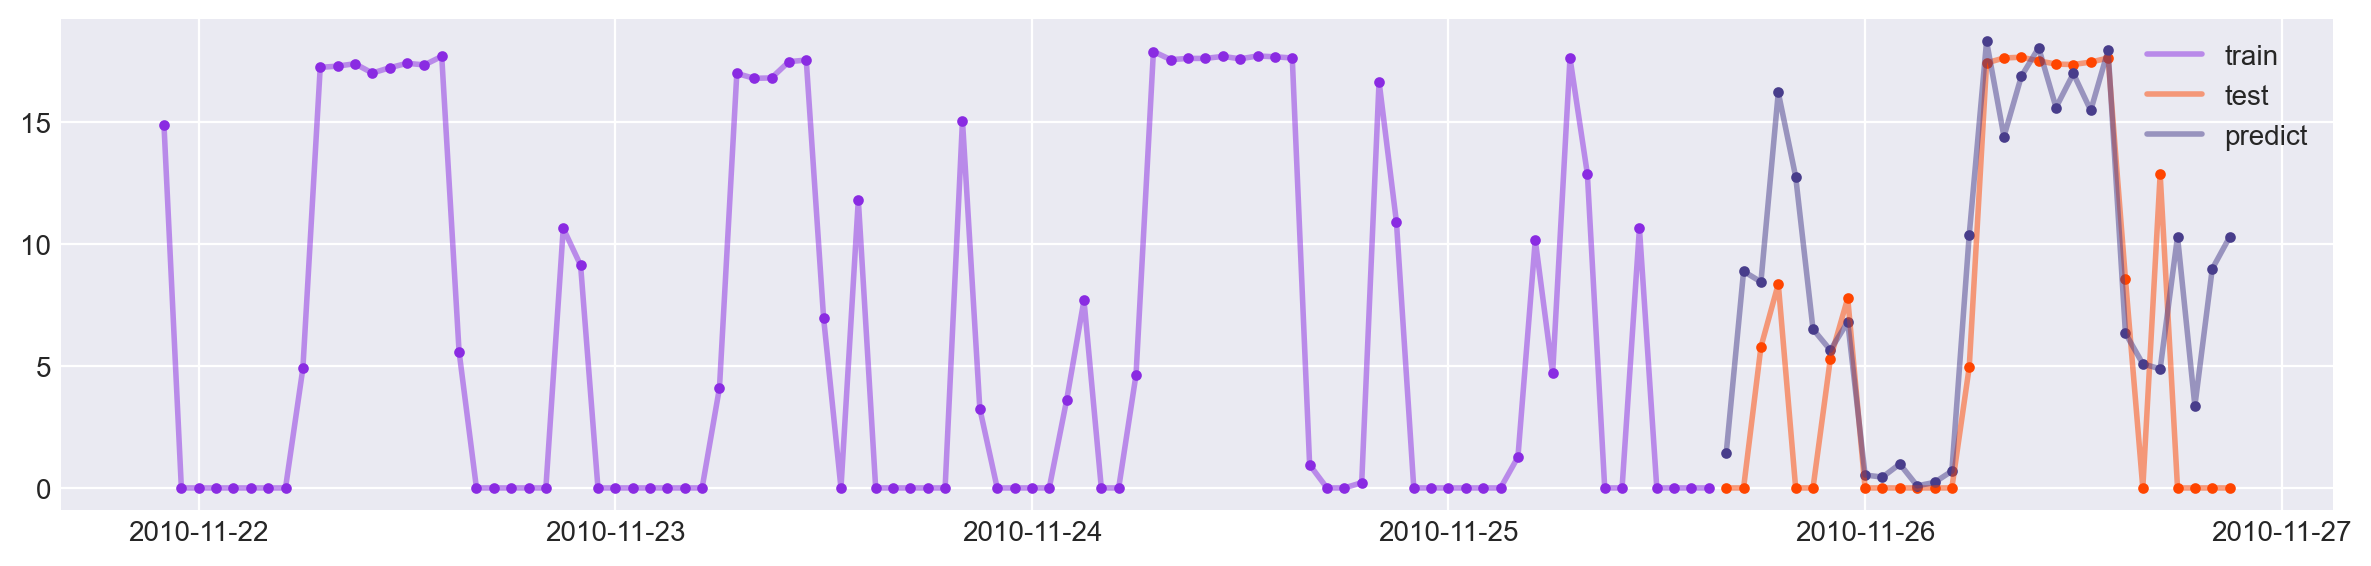

In [23]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [24]:
print(grid_search_results["params"])

{'l2_leaf_reg': 5}


In [25]:
del (
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

### Data Prep For LSTM

In [26]:
import tensorflow as tf


model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 15


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


print(f"dataframe shape {dataframe.shape}")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=TARGET_COLUMN, lags=LAGS)
    .pipe(create_window_feature, column=TARGET_COLUMN, window_len=FEATURE_WINDOW_LEN)
    .pipe(create_datetime_feature, features_name=DT_FEATURES)
    .pipe(create_cyclic_feature, features_name=CYCLIC_FEATURE)
    .pipe(drop_null_rows)
)

df_feat = build_features(dataframe)

print(f"dataframe shape after Feature Union {df_feat.shape}", end="\n\n")

data_x, data_y = seperate_target(df_feat, TARGET_COLUMN)

print(f"data_x shape after seperate_target {data_x.shape}")
print(f"data_y shape after seperate_target {data_y.shape}", end="\n\n")

scaler_x = StandardScaler()
scaler_x.fit(data_x)
data_x_np = scaler_x.transform(data_x)

scaler_y = StandardScaler()
scaler_y.fit(data_y)
data_y_np = scaler_y.transform(data_y)

print(f"data_x shape after StandardScaler {data_x_np.shape}")
print(f"data_y shape after StandardScaler {data_y_np.shape}", end="\n\n")

x_window, y_window = window_data(data_x_np, data_y_np, window_len=WINDOW_LEN)

print(f"x_window shape after Windowing {x_window.shape}")
print(f"y_window shape after Windowing {y_window.shape}", end="\n\n")

x_train_data, x_test_data = x_window[:-TEST_SIZE], x_window[-TEST_SIZE:]
y_train_data, y_test_data = y_window[:-TEST_SIZE], y_window[-TEST_SIZE:]

print(f"x_train_data shape after Test Train Split {x_train_data.shape}")
print(f"x_test_data  shape after Test Train Split {x_test_data.shape}")
print(f"y_train_data shape after Test Train Split {y_train_data.shape}")
print(f"y_test_data  shape after Test Train Split {y_test_data.shape}", end="\n\n")

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

dataframe shape (1825, 7)
dataframe shape after Feature Union (1822, 26)

data_x shape after seperate_target (1822, 25)
data_y shape after seperate_target (1822, 1)

data_x shape after StandardScaler (1822, 25)
data_y shape after StandardScaler (1822, 1)

x_window shape after Windowing (1799, 24, 25)
y_window shape after Windowing (1799, 1)

x_train_data shape after Test Train Split (1769, 24, 25)
x_test_data  shape after Test Train Split (30, 24, 25)
y_train_data shape after Test Train Split (1769, 1)
y_test_data  shape after Test Train Split (30, 1)



In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = tf.keras.models.Sequential(
    [
        LSTM(64, input_shape=x_window.shape[-2:], dropout=0.0, activation="relu"),
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(1),
    ]
)

model.compile(optimizer="adam", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=25,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

Epoch 1/25
200/200 [==============================] - 7s 24ms/step - loss: 0.4679 - mae: 0.5300 - val_loss: 0.6571 - val_mae: 0.6330
Epoch 2/25
200/200 [==============================] - 4s 22ms/step - loss: 0.2014 - mae: 0.3262 - val_loss: 0.4253 - val_mae: 0.5383
Epoch 3/25
200/200 [==============================] - 4s 21ms/step - loss: 0.1401 - mae: 0.2674 - val_loss: 0.6392 - val_mae: 0.5977
Epoch 4/25
200/200 [==============================] - 5s 24ms/step - loss: 0.1450 - mae: 0.2788 - val_loss: 0.4400 - val_mae: 0.4939
Epoch 5/25
200/200 [==============================] - 5s 23ms/step - loss: 0.0885 - mae: 0.2086 - val_loss: 0.5269 - val_mae: 0.5185
Epoch 6/25
200/200 [==============================] - 4s 21ms/step - loss: 0.0620 - mae: 0.1759 - val_loss: 0.6485 - val_mae: 0.5526
Epoch 7/25
200/200 [==============================] - 4s 22ms/step - loss: 0.0560 - mae: 0.1743 - val_loss: 0.5433 - val_mae: 0.5287
Epoch 8/25
200/200 [==============================] - 5s 23ms/step - 

In [28]:
yhat_scaled = scaler_y.inverse_transform(yhat)
y_test_data_scaled = scaler_y.inverse_transform(y_test_data)
y_train_data_scaled = scaler_y.inverse_transform(y_train_data)


print(f"yhat_scaled shape {yhat_scaled.shape} {y_test_data_scaled.shape}")
resultsDict[model_name] = evaluate(y_test_data_scaled, yhat_scaled)

yhat_scaled shape (30, 1) (30, 1)


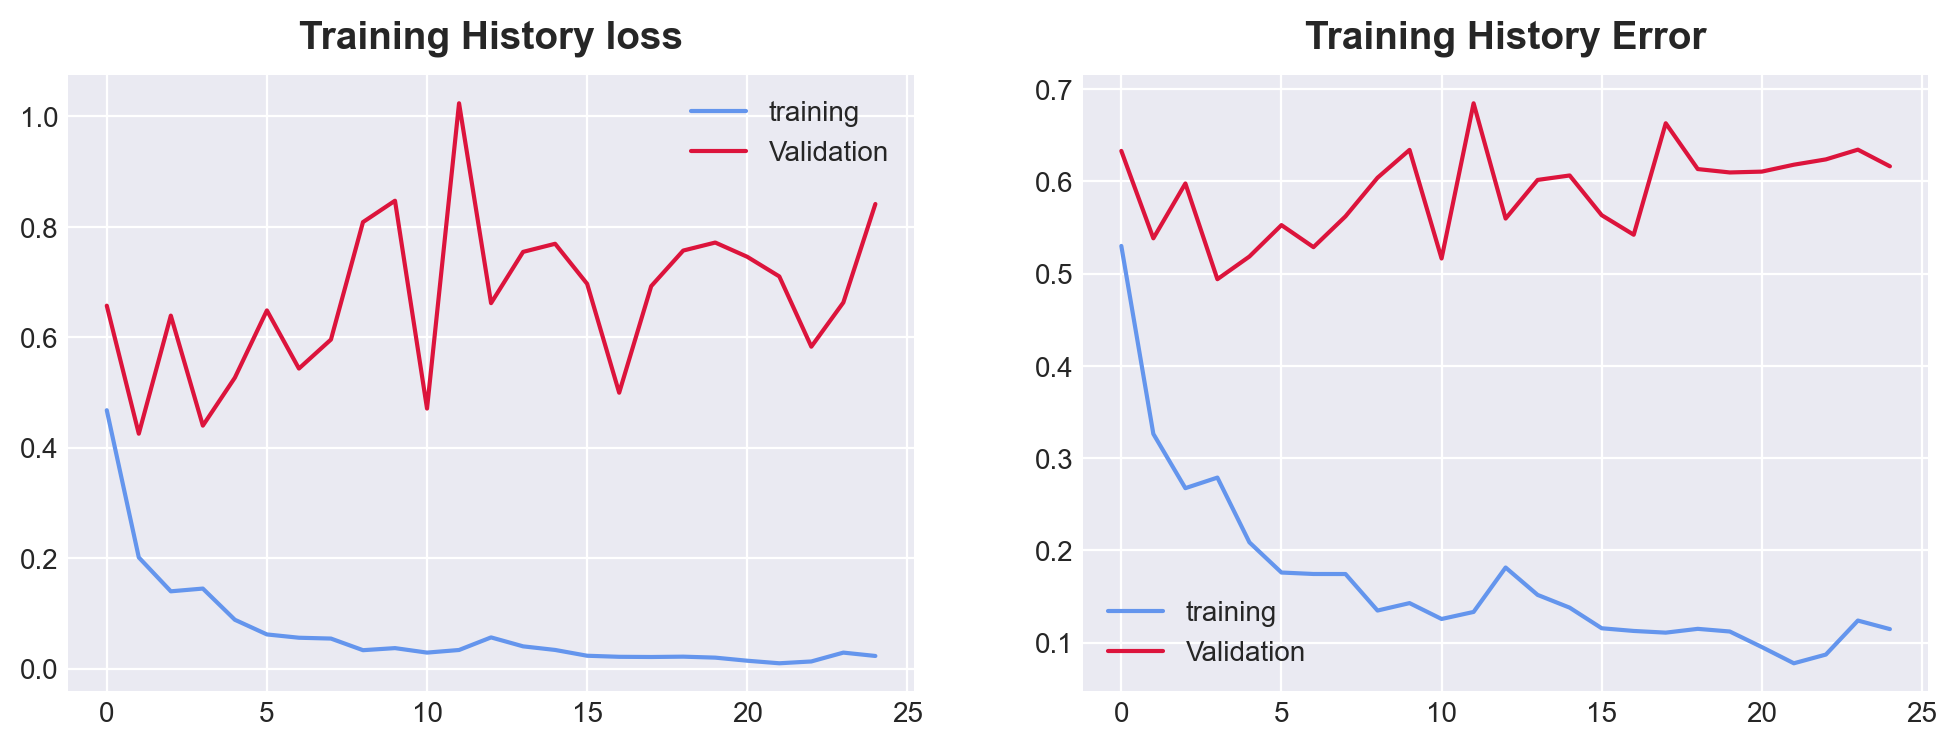

In [29]:
plot_tf_training_history(training_history)

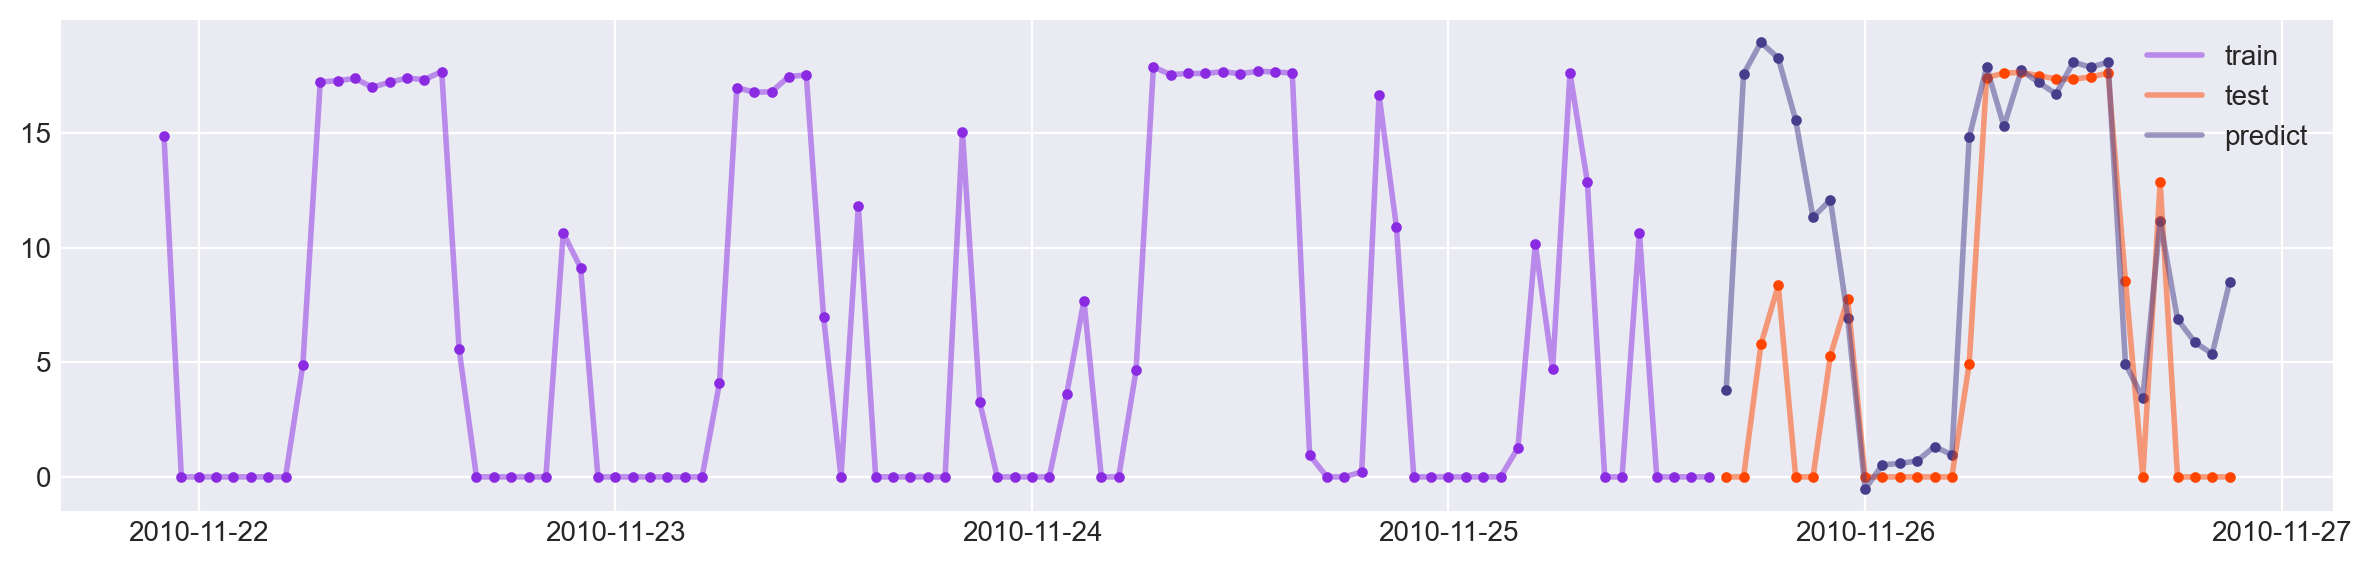

In [30]:
y_hat_df = pd.DataFrame(
    yhat_scaled, index=data_y.index[-TEST_SIZE:], columns=["TARGET_COLUMN"]
)

y_test_data_df = pd.DataFrame(
    y_test_data_scaled, index=data_y.index[-TEST_SIZE:], columns=["TARGET_COLUMN"]
)

y_train_data_df = pd.DataFrame(
    y_train_data_scaled,
    index=data_y.index[WINDOW_LEN - 1 : -TEST_SIZE],
    columns=["TARGET_COLUMN"],
)

show_series(
    [y_train_data_df[-90:], y_test_data_df, y_hat_df],
    labels=["train", "test", "predict"],
)

In [31]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

,KNeighborsRegressor,BayesianRidge,LassoCV,RandomForestRegressor,XGBRegressor,LGBMRegressor,CatBoostRegressor,LSTM_Dense
mae,3.905972e+00,4.134880e+00,4.166178e+00,3.186343e+00,3.189195e+00,3.414407e+00,3.598669e+00,4.482213e+00
rmse,4.717390e+00,5.222267e+00,5.277634e+00,4.442998e+00,4.193339e+00,4.761948e+00,5.183177e+00,6.670172e+00
mape,1.010266e+16,9.897222e+15,1.004824e+16,8.603008e+15,7.986220e+15,8.529151e+15,1.059818e+16,1.246510e+16
r2,5.974085e-01,5.066226e-01,4.961054e-01,6.428807e-01,6.818873e-01,5.897671e-01,5.139811e-01,1.951126e-01


In [32]:
resultsDF.T

,mae,rmse,mape,r2
KNeighborsRegressor,3.905972,4.717390,1.010266e+16,0.597409
BayesianRidge,4.134880,5.222267,9.897222e+15,0.506623
LassoCV,4.166178,5.277634,1.004824e+16,0.496105
RandomForestRegressor,3.186343,4.442998,8.603008e+15,0.642881
XGBRegressor,3.189195,4.193339,7.986220e+15,0.681887
LGBMRegressor,3.414407,4.761948,8.529151e+15,0.589767
CatBoostRegressor,3.598669,5.183177,1.059818e+16,0.513981
LSTM_Dense,4.482213,6.670172,1.246510e+16,0.195113


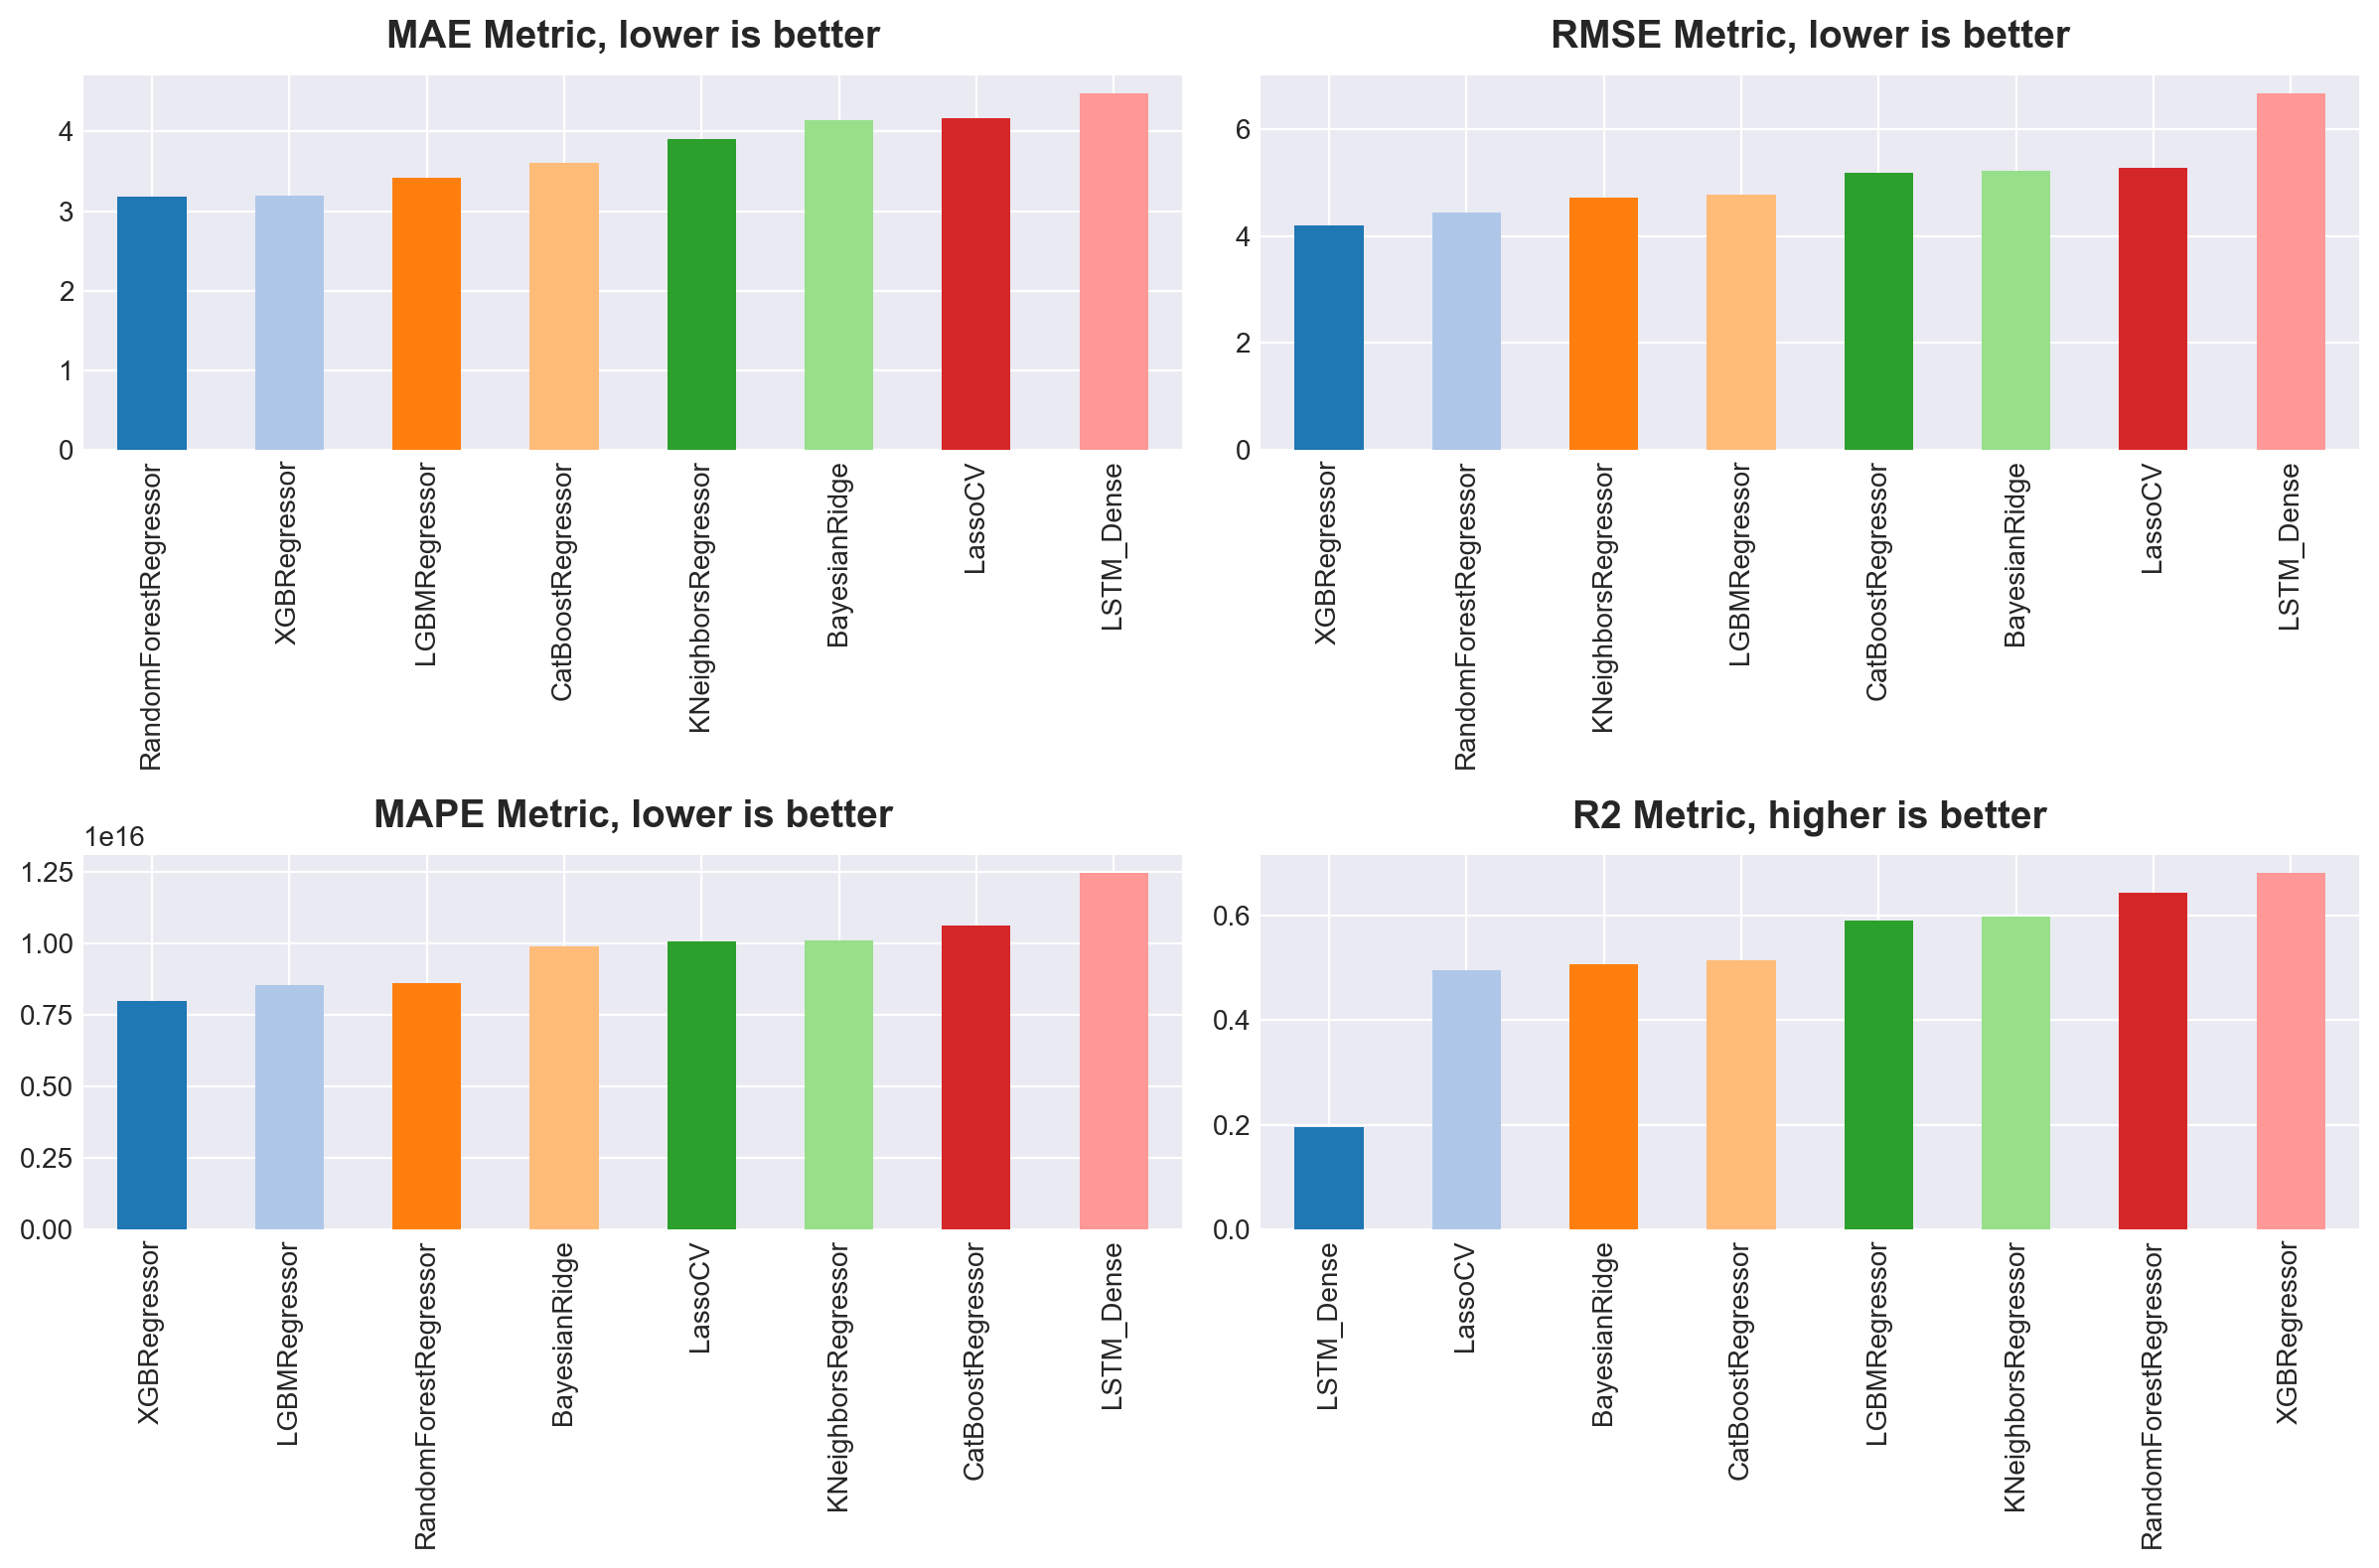

In [33]:
plot_metrics(resultsDF)

### Saving results

In [34]:
resultsDF_T = resultsDF.T.copy(deep=True)
resultsDF_T["Dataset"] = "Electricity"
resultsDF_T["Mode"] = "Singel_step"

result_path = "./results/results.csv"

if os.path.isfile(result_path) is False:
    resultsDF_T.to_csv(result_path, index=False)
else:
    result_data = pd.read_csv(result_path)
    if result_data[result_data["Dataset"] == "Electricity"].shape[0] > 0:
        result_data = result_data[result_data["Dataset"] != "Electricity"].copy()

    new_data = pd.concat([result_data, resultsDF_T])
    new_data.to_csv(result_path, index=False)